# Tutorial 1: Mysteries

**Week 2, Day 5: Mysteries**

**By Neuromatch Academy**

__Content creators:__ Samuele Bolotta, Steve Fleming, Juan David Vargas, Guillaume Dumas

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]


___


# Tutorial Objectives

*Estimated timing of tutorial: [insert estimated duration of whole tutorial in minutes]*

In this tutorial, you will observe how performance degrades as testing data distribution strays from training distribution.


In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'Link to the slides'


---
# Setup



In [2]:
# @title Install dependencies
# @markdown

!pip install numpy matplotlib Pillow torch torchvision transformers ipywidgets gradio trdg scikit-learn networkx pickleshare seaborn tabulate


In [3]:
# @title Import dependencies
# @markdown Enhanced organization and clarity in import statements for better readability

# Standard Libraries
import copy
import logging
import os
import random
import requests

# Data Handling and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.linear_model import LinearRegression
from tabulate import tabulate

# Scientific Computing and Statistical Libraries
from numpy.linalg import inv
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

# Deep Learning Libraries
import torch
from torch import nn, optim, save, load
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR

# Image Processing Libraries
from PIL import Image
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

# Interactive Elements and Web Applications
from IPython.display import IFrame
import gradio as gr
import ipywidgets as widgets
from ipywidgets import interact, IntSlider

# Graph Analysis Libraries
import networkx as nx

# Progress Monitoring Libraries
from tqdm import tqdm

# Utilities and Miscellaneous Libraries
from itertools import product

In [4]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
#@title Helper functions
# @markdown

def initialize_global():
    global Input_Size_1, Hidden_Size_1, Output_Size_1, Input_Size_2
    global num_units, patterns_number
    global learning_rate_1, learning_rate_2, n_epochs, momentum, temperature , Threshold
    global First_set, Second_set, Third_set
    global First_set_targets, Second_set_targets, Third_set_targets
    global epoch_list, epoch_1_order, epoch_2_order, patterns_matrix1
    global Testing_graph_names

    # Network sizes
    Input_Size_1 = 100
    Hidden_Size_1 = 60
    Output_Size_1 = 100
    Input_Size_2 = 100

    # Patterns
    num_units = 100
    patterns_number = 200

    # Pre-training and hyperparameters
    learning_rate_1 = 0.9
    learning_rate_2 = 0.1
    n_epochs = 200
    momentum = 0.0
    temperature = 1.0
    Threshold=0.5

    # Testing
    First_set = []
    Second_set = []
    Third_set = []
    First_set_targets = []
    Second_set_targets = []
    Third_set_targets = []

    Testing_graph_names = ["Suprathreshold stimulus", "Subthreshold stimulus", "Low Vision"]


    # Graphic of pretraining
    epoch_list = list(range(1, n_epochs + 1))
    epoch_1_order = np.zeros(n_epochs)
    epoch_2_order = np.zeros(n_epochs)
    patterns_matrix1 =  torch.zeros((n_epochs, patterns_number), device=device)  # Initialize patterns_matrix as a PyTorch tensor on the GPU
    
class SecondOrderNetwork(nn.Module):
    def __init__(self, use_gelu):
        super(SecondOrderNetwork, self).__init__()
        # Define a linear layer for comparing the difference between input and output of the first-order network
        self.comparison_layer = nn.Linear(100, 100)
        
        # Linear layer for determining wagers, mapping from 100 features to a single output
        self.wager = nn.Linear(100, 1)
        
        # Dropout layer to prevent overfitting by randomly setting input units to 0 with a probability of 0.3 during training
        self.dropout = nn.Dropout(0.3)
        
        # Select activation function based on the `use_gelu` flag
        self.activation = torch.nn.GELU() if use_gelu else torch.relu
        
        # Additional activation functions for potential use in network operations
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax for multi-class classification problems
        self.tanh = torch.tanh
        
        # Initialize the weights of the network
        self._init_weights()

    def _init_weights(self):
        # Uniformly initialize weights for the comparison and wager layers
        init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):
        # Calculate the difference between the first-order input and output
        comparison_matrix = first_order_input - first_order_output
        
        # Pass the difference through the comparison layer and apply the chosen activation function
        comparison_out = self.comparison_layer(comparison_matrix)
        
        # Calculate the wager value, applying dropout and sigmoid activation to the output of the wager layer
        wager = self.dropout(self.sigmoid(self.wager(comparison_out)))
        
        return wager

def compute_metrics(TP, FP, FN):
    """Compute precision, recall, and F1 score."""
    precision = round(TP / (TP + FP), 2) if (TP + FP) > 0 else 0
    recall = round(TP / (TP + FN), 2) if (TP + FN) > 0 else 0
    f1_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

def create_patterns(stimulus):
    """
    Generates neural network input patterns based on specified stimulus conditions.

    Parameters:
    - stimulus (int): Determines the type of patterns to generate. 
                      Acceptable values:
                      - 0: Suprathreshold stimulus
                      - 1: Subthreshold stimulus
                      - 2: Low vision condition
    
    Returns:
    - torch.Tensor: Tensor of generated patterns.
    - torch.Tensor: Tensor of target values corresponding to the generated patterns.
    """

    # Generate initial patterns and target tensors for base condition.
    patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

    if stimulus == 0:  # Suprathreshold stimulus condition
        # Convert pattern tensors for processing on specified device (CPU/GPU).
        patterns = torch.Tensor(patterns_tensor).to(device)
        targets = torch.Tensor(stim_present_tensor).to(device)

    elif stimulus == 1:  # Subthreshold stimulus condition, simulating blindsight with added noise
        patterns, targets = generate_subthreshold_patterns(patterns_number, num_units, device)

    elif stimulus == 2:  # Low vision condition, reducing stimulus activation
        patterns, targets = generate_low_vision_patterns(patterns_number, num_units, device)

    else:
        raise ValueError("Invalid stimulus ID for testing patterns creation.")

    return patterns, targets

def generate_subthreshold_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the subthreshold stimulus condition by adding noise.
    
    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.
    
    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units) + 0.0012  # Base pattern with noise
        if i >= 100:
            stimulus_number = random.randint(0, 99)  # Selecting unit for stimulus
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0) + 0.0012
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.5 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

def generate_low_vision_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the low vision condition by reducing stimulus activation.
    
    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.
    
    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units)
        if i >= 100:
            stimulus_number = random.randint(0, 99)
            pattern[stimulus_number] = np.random.uniform(0.0, 0.3)
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.15 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

  #define the architecture, optimizers, loss functions, and schedulers for pre training
def prepare_pre_training(hidden,factor,gelu,stepsize, gam):

  first_order_network = FirstOrderNetwork(hidden,factor,gelu).to(device)
  second_order_network = SecondOrderNetwork(gelu).to(device)

  criterion_1 = nn.MSELoss()
  criterion_2 = nn.MSELoss()

  optimizer_1 = optim.SGD(first_order_network.parameters(), lr=learning_rate_1, momentum=momentum)
  optimizer_2 = optim.SGD(second_order_network.parameters(), lr=learning_rate_2, momentum=momentum)


  # Learning rate schedulers
  scheduler_1 = StepLR(optimizer_1, step_size=stepsize, gamma=gam)
  scheduler_2 = StepLR(optimizer_2, step_size=stepsize, gamma=gam)

  return first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2

def title(string):
  #plot the title of the currently trained model, inside a rectangle
  fig, ax = plt.subplots()
  rectangle = patches.Rectangle((0.05, 0.1), 0.9 , 0.4, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.5)
  ax.add_patch(rectangle)
  plt.text(0.5, 0.3, string , horizontalalignment='center', verticalalignment='center', fontsize=26, color='white')
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  ax.axis('off')
  plt.show()
  plt.close(fig)

# Function to configure the training environment and load the models
def config_training(first_order_network, second_order_network, hidden, factor, gelu):
    """
    Configures the training environment by saving the state of the given models and loading them back.
    Initializes testing patterns for evaluation.

    Parameters:
    - first_order_network: The first order network instance.
    - second_order_network: The second order network instance.
    - hidden: Number of hidden units in the first order network.
    - factor: Factor influencing the network's architecture.
    - gelu: Activation function to be used in the network.

    Returns:
    - Tuple of testing patterns, number of samples in the testing patterns, and the loaded model instances.
    """
    # Paths where the models' states will be saved
    PATH = './cnn1.pth'
    PATH_2 = './cnn2.pth'

    # Save the weights of the pretrained networks to the specified paths
    torch.save(first_order_network.state_dict(), PATH)
    torch.save(second_order_network.state_dict(), PATH_2)

    # Generating testing patterns for three different sets
    First_set, First_set_targets = create_patterns(0)
    Second_set, Second_set_targets = create_patterns(1)
    Third_set, Third_set_targets = create_patterns(2)

    # Aggregate testing patterns and their targets for ease of access
    Testing_patterns = [[First_set, First_set_targets], [Second_set, Second_set_targets], [Third_set, Third_set_targets]]

    # Determine the number of samples from the first set (assumed consistent across all sets)
    n_samples = len(Testing_patterns[0][0])

    # Initialize and load the saved states into model instances
    loaded_model = FirstOrderNetwork(hidden, factor, gelu)
    loaded_model_2 = SecondOrderNetwork(gelu)

    loaded_model.load_state_dict(torch.load(PATH))
    loaded_model_2.load_state_dict(torch.load(PATH_2))

    # Ensure the models are moved to the appropriate device (CPU/GPU) and set to evaluation mode
    loaded_model.to(device)
    loaded_model_2.to(device)

    loaded_model.eval()
    loaded_model_2.eval()

    return Testing_patterns, n_samples, loaded_model, loaded_model_2

# Function to test the model using the configured testing patterns
def testing(Testing_patterns, n_samples, loaded_model, loaded_model_2):
    """
    Tests the model on provided testing patterns and calculates F1 scores and other metrics for analysis.

    Parameters:
    - Testing_patterns: A list of testing datasets and their targets.
    - n_samples: Number of samples in each testing dataset.
    - loaded_model: The loaded first order network model for testing.
    - loaded_model_2: The loaded second order network model for testing.

    Returns:
    - F1 scores for high and low wager scenarios, and results for plotting.
    """
    results_for_plotting = []

    f1_scores_high_wager = []
    f1_scores_low_wager = []

    # Iterate through each set of testing patterns and targets
    for i in range(len(Testing_patterns)):
        with torch.no_grad():  # Ensure no gradients are computed during testing
            # Obtain output from the first order model
            output_first_order = loaded_model(Testing_patterns[i][0])
            # Focus on the last 100 elements for wagering analysis
            last_100_elements_wager = output_first_order[-100:].cpu()
            max_values = last_100_elements_wager.max(dim=1).values

            _, targets_2 = torch.max(Testing_patterns[i][1], 1)
            targets_2 = targets_2[-100:].cpu()
            # Convert targets to binary classification for wagering scenario
            targets_2 = (targets_2 > 0).int()

            # Convert tensors to NumPy arrays for metric calculations
            predicted_np = max_values.numpy()
            targets_2_np = targets_2.numpy()

            # Calculate True Positives, True Negatives, False Positives, and False Negatives
            TP = np.sum((predicted_np > 0.5) & (targets_2_np > 0.5))
            TN = np.sum((predicted_np < 0.5) & (targets_2_np < 0.5))
            FP = np.sum((predicted_np > 0.5) & (targets_2_np < 0.5))
            FN = np.sum((predicted_np < 0.5) & (targets_2_np > 0.5))

            # Compute precision, recall, and F1 score for both high and low wager scenarios
            precision_h, recall_h, f1_score_h = compute_metrics(TP, FP, FN)
            precision_l, recall_l, f1_score_l = compute_metrics(TP, FP, FN)

            f1_scores_high_wager.append(f1_score_h)
            f1_scores_low_wager.append(f1_score_l)

            # Collect results for plotting
            results_for_plotting.append({
                "counts": [[TP, FP, TP + FP], [FN, TN, FN + TN], [TP + FN, FP + TN, TP + FP + FN + TN]],
                "metrics": [[precision_h, recall_h, f1_score_h], [precision_l, recall_l, f1_score_l]],
                "title_results": f"Results Table - Set {i+1}",
                "title_metrics": f"Metrics Table - Set {i+1}"
            })

    return f1_scores_high_wager, f1_scores_low_wager, results_for_plotting

def Generate_Patterns(patterns_number, num_units):
    # Generates patterns and targets for training the networks
    # patterns_number: Number of patterns to generate
    # num_units: Number of units in each pattern
    # Returns lists of patterns, stimulus present/absent indicators, and second order targets

    patterns = []  # Store generated patterns
    stim_present = []  # Indicators for when a stimulus is present in the pattern
    stim_absent = []  # Indicators for when no stimulus is present
    order_2_pr = []  # Second order network targets based on the presence or absence of stimulus

    # Generate patterns, half noise and half potential stimuli
    for i in range(patterns_number):
        # First half: Noise patterns
        if i < patterns_number // 2:
            pattern = np.random.uniform(0.0, 0.02, num_units)  # Generate a noise pattern
            patterns.append(pattern)
            stim_present.append(np.zeros(num_units))  # Stimulus absent
            stim_absent.append(np.zeros(num_units))  # Redundant, consider removing
            order_2_pr.append([0.0 , 1.0])  # No stimulus, low wager
        # Second half: Stimulus patterns
        else:
            stimulus_number = random.randint(0, num_units - 1)  # Choose a unit for potential stimulus
            pattern = np.random.uniform(0.0, 0.02, num_units)
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0)  # Set stimulus intensity
            patterns.append(pattern)
            present = np.zeros(num_units)
            # Determine if stimulus is above discrimination threshold
            if pattern[stimulus_number] >= 0.5:
                order_2_pr.append([1.0 , 0.0])  # Stimulus detected, high wager
                present[stimulus_number] = 1.0
            else:
                order_2_pr.append([0.0 , 1.0])  # Stimulus not detected, low wager
                present[stimulus_number] = 0.0
            stim_present.append(present)
            stim_absent.append(np.zeros(num_units))  # Redundant, consider removing

    patterns_tensor = torch.Tensor(patterns).to(device)
    stim_present_tensor = torch.Tensor(stim_present).to(device)
    stim_absent_tensor= torch.Tensor(stim_absent).to(device)
    order_2_tensor = torch.Tensor(order_2_pr).to(device)

    return patterns_tensor, stim_present_tensor , stim_absent_tensor, order_2_tensor

def create_patterns(stimulus):
    """
    Generates neural network input patterns based on specified stimulus conditions.

    Parameters:
    - stimulus (int): Determines the type of patterns to generate. 
                      Acceptable values:
                      - 0: Suprathreshold stimulus
                      - 1: Subthreshold stimulus
                      - 2: Low vision condition
    
    Returns:
    - torch.Tensor: Tensor of generated patterns.
    - torch.Tensor: Tensor of target values corresponding to the generated patterns.
    """

    # Generate initial patterns and target tensors for base condition.
    patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

    if stimulus == 0:  # Suprathreshold stimulus condition
        # Convert pattern tensors for processing on specified device (CPU/GPU).
        patterns = torch.Tensor(patterns_tensor).to(device)
        targets = torch.Tensor(stim_present_tensor).to(device)

    elif stimulus == 1:  # Subthreshold stimulus condition, simulating blindsight with added noise
        patterns, targets = generate_subthreshold_patterns(patterns_number, num_units, device)

    elif stimulus == 2:  # Low vision condition, reducing stimulus activation
        patterns, targets = generate_low_vision_patterns(patterns_number, num_units, device)

    else:
        raise ValueError("Invalid stimulus ID for testing patterns creation.")

    return patterns, targets

def generate_subthreshold_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the subthreshold stimulus condition by adding noise.
    
    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.
    
    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units) + 0.0012  # Base pattern with noise
        if i >= 100:
            stimulus_number = random.randint(0, 99)  # Selecting unit for stimulus
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0) + 0.0012
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.5 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

def generate_low_vision_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the low vision condition by reducing stimulus activation.
    
    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.
    
    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units)
        if i >= 100:
            stimulus_number = random.randint(0, 99)
            pattern[stimulus_number] = np.random.uniform(0.0, 0.3)
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.15 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

In [6]:
# @title Plotting functions
# @markdown

def plot_signal_max_and_indicator(patterns_tensor, plot_title="Training Signals"):
    """
    Plots the maximum values of signal units and a binary indicator for max values greater than 0.5.

    Parameters:
    - patterns_tensor: A tensor containing signals, where each signal is expected to have multiple units.
    """

    # Calculate the maximum value of units for each signal within the patterns tensor
    max_values_of_units = patterns_tensor.max(dim=1).values.cpu().numpy()  # Ensure it's on CPU and in NumPy format for plotting

    # Determine the binary indicators based on the max value being greater than 0.5
    binary_indicators = (max_values_of_units > 0.5).astype(int)

    # Create a figure with 2 subplots (2 rows, 1 column)
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    fig.suptitle(plot_title, fontsize=16)  # Set the overall title for the plot

    # First subplot for the maximum values of each signal
    axs[0].plot(range(patterns_tensor.size(0)), max_values_of_units, drawstyle='steps-mid')
    axs[0].set_xlabel('Signal Number')
    axs[0].set_ylabel('Max Value of Signal Units')
    axs[0].grid(True)

    # Second subplot for the binary indicators
    axs[1].plot(range(patterns_tensor.size(0)), binary_indicators, drawstyle='steps-mid', color='red')
    axs[1].set_xlabel('Signal Number')
    axs[1].set_ylabel('Indicator (Max > 0.5) in each signal')
    axs[1].set_ylim(-0.1, 1.1)  # Adjust y-axis limits for clarity
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def pre_train_plots(epoch_1_order, epoch_2_order, title):
    # LOSS PLOTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

    # First graph for 1st Order Network
    ax1.plot(epoch_list, epoch_1_order, linestyle='--', marker='o', color='g')
    ax1.set_title('1st Order Network Loss')
    ax1.set_xlabel('Epochs - Pretraining Phase')
    ax1.set_ylabel('Loss')

    # Second graph for 2nd Order Network
    ax2.plot(epoch_list, epoch_2_order, linestyle='--', marker='o', color='b')
    ax2.set_title('2nd Order Network Loss')
    ax2.set_xlabel('Epochs - Pretraining Phase')
    ax2.set_ylabel('Loss')

    plt.suptitle(title, fontsize=16, y=0.95)

    plt.tight_layout()
    plt.savefig('Blindsight_Pre_training_Loss_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
    plt.show()
    plt.close(fig)

def plot_testing(results_for_plotting , title):
    """Plot a table focused on 'PRECISION', 'RECALL', 'F1 SCORE', indicating consciousness level and testing scenario."""
    fig, ax = plt.subplots(figsize=(10, len(results_for_plotting) * 2 + 2))  # Adjusted for added header space
    ax.axis('off')
    ax.axis('tight')

    # Define column labels
    col_labels = ["Scenario", "Consciousness Level", "PRECISION", "RECALL", "F1 SCORE"]

    # Initialize list to hold all rows of data including headers
    full_data = []

    # Process each result to extract and prepare the data rows
    for i, result in enumerate(results_for_plotting):
        for level, metrics in zip(["High Consciousness", "Low Consciousness"], result["metrics"]):
            row = [Testing_graph_names[i], level] + metrics
            full_data.append(row)

    # Extract metric values for color scaling (excluding the first two columns which are text)
    metric_values = np.array(full_data)[:, 2:].astype(float)  # Convert to float for color scaling
    max_value = np.max(metric_values)
    colors = metric_values / max_value  # Normalize for color mapping

    # Prepare colors for all cells, defaulting to white for non-metric cells
    cell_colors = [["white", "white"] + list(row) for row in plt.cm.RdYlGn(colors)]

    # Create the table with cell colors
    table = ax.table(cellText=full_data, colLabels=col_labels, loc='center', cellLoc='center', cellColours=cell_colors)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.title(title, pad=20, fontsize=16)
    plt.show()

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.
# @markdown

# inform the user if the notebook uses GPU or CPU.

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

# Section 1a: Modularity Of The Mind

The crucial idea behind this section is that machine learning aims to capture the modular structure of the physical world, where complexity emerges from simpler, independently evolving subsystems. This concept aligns with causal inference, suggesting that understanding and modeling the world involves identifying and integrating these autonomous mechanisms. These mechanisms, which interact sparsely, maintain their functionality even amidst changes in others, highlighting their robustness. Recurrent Independent Mechanisms (RIMs) embody this principle by operating mostly independently, occasionally interacting through an attention-based mechanism for efficient and dynamic information processing. This approach [https://arxiv.org/pdf/1909.10893.pdf] suggests a preference for models that can capture the independence and sparse interactions of mechanisms, potentially leading to more adaptable and generalizable AI systems.

In [8]:
# @title Data retrieval
# @markdown

# URL of the repository to clone
!git clone https://github.com/SamueleBolotta/RIMs-Sequential-MNIST
%cd RIMs-Sequential-MNIST

# Imports
from data import MnistData
from networks import MnistModel, LSTM

# Function to download files 
def download_file(url, destination):
    print(f"Starting to download {url} to {destination}")
    response = requests.get(url, allow_redirects=True)
    open(destination, 'wb').write(response.content)
    print(f"Successfully downloaded {url} to {destination}")

# Path of the models
model_path = {
    'LSTM': 'lstm_model_dir/lstm_best_model.pt',
    'RIM': 'rim_model_dir/best_model.pt'
}

# URLs of the models
model_urls = {
    'LSTM': 'https://osf.io/4gajq/download',
    'RIM': 'https://osf.io/3squn/download'
}

# Check if model files exist, if not, download them
for model_key, model_url in model_urls.items():
    if not os.path.exists(model_path[model_key]):
        download_file(model_url, model_path[model_key])
        print(f"{model_key} model downloaded.")
    else:
        print(f"{model_key} model already exists. No download needed.")

fatal: destination path 'RIMs-Sequential-MNIST' already exists and is not an empty directory.
/home/samuele/Documenti/GitHub/NeuroAI_Course/tutorials/W2D5_Mysteries/RIMs-Sequential-MNIST
LSTM model already exists. No download needed.
RIM model already exists. No download needed.


# RIMs

The model has been trained on the Sequential MNIST datset with individual image size 14x14. To assess its generalization capabilities, it got tested on 16x16 (Validation Set 3), 19x19 (Validation Set 2) and 24x24 images (Validation Set 3).

In [9]:
# Config
config = {
    'cuda': True,
    'epochs': 200,
    'batch_size': 64,
    'hidden_size': 100,
    'input_size': 1,
    'model': 'RIM', # Or 'RIM' for the MnistModel
    'train': False, # Set to False to load the saved model
    'num_units': 6,
    'rnn_cell': 'LSTM',
    'key_size_input': 64,
    'value_size_input': 400,
    'query_size_input': 64,
    'num_input_heads': 1,
    'num_comm_heads': 4,
    'input_dropout': 0.1,
    'comm_dropout': 0.1,
    'key_size_comm': 32,
    'value_size_comm': 100,
    'query_size_comm': 32,
    'k': 4,
    'size': 14,
    'loadsaved': 1, # Ensure this is 1 to load saved model
    'log_dir': 'rim_model_dir'
}

# Choose the model
model = MnistModel(config)  # Instantiating MnistModel (RIM) with config
model_directory = model_path['RIM']

# Set device
device = set_device()
model.to(device)

# Set the map_location based on whether CUDA is available
map_location = 'cuda' if torch.cuda.is_available() and config['cuda'] else 'cpu'

# Use torch.load with the map_location parameter
saved = torch.load(model_directory, map_location=map_location)
model.load_state_dict(saved['net'])

# Data
data = MnistData(config['batch_size'], (config['size'], config['size']), config['k'])

# Evaluation function
def test_model(model, loader, func):
    accuracy = 0
    loss = 0
    model.eval()
    
    print(f"Total validation samples: {loader.val_len()}")  # Print total number of validation samples

    with torch.no_grad():
        for i in tqdm(range(loader.val_len())):
            test_x, test_y = func(i)
            test_x = model.to_device(test_x)
            test_y = model.to_device(test_y).long()
            probs  = model(test_x)
            preds = torch.argmax(probs, dim=1)
            correct = preds == test_y
            accuracy += correct.sum().item()
            
    accuracy /= 100  # Use the total number of items in the validation set for accuracy calculation
    return accuracy

    
# Evaluate on all three validation sets
validation_functions = [data.val_get1, data.val_get2, data.val_get3]
validation_accuracies_rim = []

print(f"Model: {config['model']}, Device: {device}")
print(f"Configuration: {config}")

for func in validation_functions:
    accuracy = test_model(model, data, func)
    validation_accuracies_rim.append(accuracy)

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Model: RIM, Device: cuda
Configuration: {'cuda': True, 'epochs': 200, 'batch_size': 64, 'hidden_size': 100, 'input_size': 1, 'model': 'RIM', 'train': False, 'num_units': 6, 'rnn_cell': 'LSTM', 'key_size_input': 64, 'value_size_input': 400, 'query_size_input': 64, 'num_input_heads': 1, 'num_comm_heads': 4, 'input_dropout': 0.1, 'comm_dropout': 0.1, 'key_size_comm': 32, 'value_size_comm': 100, 'query_size_comm': 32, 'k': 4, 'size': 14, 'loadsaved': 1, 'log_dir': 'rim_model_dir'}
Total validation samples: 20


100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]


Total validation samples: 20


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.85it/s]


Total validation samples: 20


100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


# LSTM

Let's now repeat the same process with LSTMs.

In [10]:
# Config
config = {
    'cuda': True,
    'epochs': 200,
    'batch_size': 64,
    'hidden_size': 100,
    'input_size': 1,
    'model': 'LSTM', 
    'train': False, # Set to False to load the saved model
    'num_units': 6,
    'rnn_cell': 'LSTM',
    'key_size_input': 64,
    'value_size_input': 400,
    'query_size_input': 64,
    'num_input_heads': 1,
    'num_comm_heads': 4,
    'input_dropout': 0.1,
    'comm_dropout': 0.1,
    'key_size_comm': 32,
    'value_size_comm': 100,
    'query_size_comm': 32,
    'k': 4,
    'size': 14,
    'loadsaved': 1, # Ensure this is 1 to load saved model
    'log_dir': 'rim_model_dir'
}

model = LSTM(config)  # Instantiating LSTM with config
model_directory = model_path['LSTM']

# Set device
device = set_device()
model.to(device)

# Set the map_location based on whether CUDA is available
map_location = 'cuda' if torch.cuda.is_available() and config['cuda'] else 'cpu'

# Use torch.load with the map_location parameter
saved = torch.load(model_directory, map_location=map_location)
model.load_state_dict(saved['net'])

# Data
data = MnistData(config['batch_size'], (config['size'], config['size']), config['k'])

# Evaluation function
def test_model(model, loader, func):
    accuracy = 0
    loss = 0
    model.eval()
    
    print(f"Total validation samples: {loader.val_len()}")  # Print total number of validation samples

    with torch.no_grad():
        for i in tqdm(range(loader.val_len())):
            test_x, test_y = func(i)
            test_x = model.to_device(test_x)
            test_y = model.to_device(test_y).long()
            probs  = model(test_x)
            preds = torch.argmax(probs, dim=1)
            correct = preds == test_y
            accuracy += correct.sum().item()
            
    accuracy /= 100  # Use the total number of items in the validation set for accuracy calculation
    return accuracy

    
# Evaluate on all three validation sets
validation_functions = [data.val_get1, data.val_get2, data.val_get3]
validation_accuracies_lstm = []

print(f"Model: {config['model']}, Device: {device}")
print(f"Configuration: {config}")

for func in validation_functions:
    accuracy = test_model(model, data, func)
    validation_accuracies_lstm.append(accuracy)

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Model: LSTM, Device: cuda
Configuration: {'cuda': True, 'epochs': 200, 'batch_size': 64, 'hidden_size': 100, 'input_size': 1, 'model': 'LSTM', 'train': False, 'num_units': 6, 'rnn_cell': 'LSTM', 'key_size_input': 64, 'value_size_input': 400, 'query_size_input': 64, 'num_input_heads': 1, 'num_comm_heads': 4, 'input_dropout': 0.1, 'comm_dropout': 0.1, 'key_size_comm': 32, 'value_size_comm': 100, 'query_size_comm': 32, 'k': 4, 'size': 14, 'loadsaved': 1, 'log_dir': 'rim_model_dir'}
Total validation samples: 20


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.89it/s]


Total validation samples: 20


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 33.90it/s]


Total validation samples: 20


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 42.03it/s]


In [11]:
# Print accuracies for all validation sets (RIMs)
for i, accuracy in enumerate(validation_accuracies_rim, 1):
    print(f'Validation Set {i} Accuracy (RIMs): {accuracy:.2f}%')

# Print accuracies for all validation sets (LSTM)
for i, accuracy in enumerate(validation_accuracies_lstm, 1):
    print(f'Validation Set {i} Accuracy (LSTM): {accuracy:.2f}%')

Validation Set 1 Accuracy (RIMs): 35.15%
Validation Set 2 Accuracy (RIMs): 64.61%
Validation Set 3 Accuracy (RIMs): 74.01%
Validation Set 1 Accuracy (LSTM): 15.18%
Validation Set 2 Accuracy (LSTM): 44.17%
Validation Set 3 Accuracy (LSTM): 72.68%


As you can see, the accuracy on 16x16 images is not extremely different. However, RIMs generalize way more robustly to 19x19 and 24x24 images. To achieve this, the authors built recurrent networks that are modular in nature, with each module being independent of the other modules and only interacting sparsely through attention. In this way, each module can learn different aspects of the environment and is only responsible for ensuring similar performance on the same aspect of a different environment.

## Discussion point

10 minutes

---
# Section 1b: Global Neural Workspace

As we have seen, deep learning has shifted towards structured models with specialized modules that enhance scalability and generalization. But we can go one step further. Inspired by the 1980s AI focus on modular architectures and the Global Workspace Theory from cognitive neuroscience, the approach [https://arxiv.org/pdf/2103.01197.pdf] we are going to analyse in this section employs a shared global workspace for module coordination. It promotes flexibility and systematic generalization by allowing dynamic interactions among specialized modules. This model emphasizes the importance of having a number of sparsely communicating specialist modules interact via a shared working memory, aiming to achieve coherent and efficient behavior across the system. 

RIMs leverage a self-attention mechanism to enable information sharing among specialist modules, traditionally through pairwise interactions where each module attends to every other. This new approach, however, introduces a shared workspace with limited capacity to streamline this process. At each computational step, specialist modules compete for the opportunity to write to this shared workspace. Subsequently, the information stored in the workspace is broadcasted to all specialists simultaneously, enhancing coordination and information flow among the modules without the need for direct pairwise communication.

## Coding Exercise: Creating a Shared Workspace

Specialists compete to write their information into the shared workspace. This process is guided by a key-query-value attention mechanism, where the competition is realized through attention scores determining which specialists' information is most critical to be updated in the workspace.

In [12]:
torch.manual_seed(42)  # Ensure reproducibility

In [13]:
class SharedWorkspace(nn.Module):
    
    def __init__(self, num_specialists, hidden_dim, num_memory_slots, memory_slot_dim):
        #################################################
        ## TODO for students: fill in the missing variables ##
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################
        super().__init__()
        self.num_specialists = num_specialists
        self.hidden_dim = hidden_dim
        self.num_memory_slots = num_memory_slots
        self.memory_slot_dim = memory_slot_dim
        self.workspace_memory = nn.Parameter(torch.randn(num_memory_slots, memory_slot_dim))
        
        # Attention mechanism components for writing to the workspace
        self.key = ...
        self.query = ...
        self.value = nn.Linear(hidden_dim, memory_slot_dim)
    
    def write_to_workspace(self, specialists_states):
        #################################################
        ## TODO for students: fill in the missing variables ##
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################
        # Flatten specialists' states if they're not already
        specialists_states = specialists_states.view(-1, self.hidden_dim)
        
        # Compute key, query, and value
        keys = self.key(specialists_states)
        query = self.query(self.workspace_memory)
        values = self.value(specialists_states)
        
        # Compute attention scores and apply softmax
        attention_scores = torch.matmul(query, keys.transpose(-2, -1)) / (self.memory_slot_dim ** 0.5)
        attention_probs = ...
        
        # Update workspace memory with weighted sum of values
        updated_memory = torch.matmul(attention_probs, values)
        self.workspace_memory = nn.Parameter(updated_memory)
        
        return self.workspace_memory

    def forward(self, specialists_states):
        #################################################
        ## TODO for students: fill in the missing variables ##
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################
        updated_memory = ...
        return updated_memory

In [14]:
# to remove solution

class SharedWorkspace(nn.Module):
    
    def __init__(self, num_specialists, hidden_dim, num_memory_slots, memory_slot_dim):
        super().__init__()
        self.num_specialists = num_specialists
        self.hidden_dim = hidden_dim
        self.num_memory_slots = num_memory_slots
        self.memory_slot_dim = memory_slot_dim
        self.workspace_memory = nn.Parameter(torch.randn(num_memory_slots, memory_slot_dim))

        # Attention mechanism components for writing to the workspace
        self.key = nn.Linear(hidden_dim, memory_slot_dim)
        self.query = nn.Linear(memory_slot_dim, memory_slot_dim)
        self.value = nn.Linear(hidden_dim, memory_slot_dim)

    def write_to_workspace(self, specialists_states):
        # Flatten specialists' states if they're not already
        specialists_states = specialists_states.view(-1, self.hidden_dim)

        # Compute key, query, and value
        keys = self.key(specialists_states)
        query = self.query(self.workspace_memory)
        values = self.value(specialists_states)

        # Compute attention scores and apply softmax
        attention_scores = torch.matmul(query, keys.transpose(-2, -1)) / (self.memory_slot_dim ** 0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Update workspace memory with weighted sum of values
        updated_memory = torch.matmul(attention_probs, values)
        self.workspace_memory = nn.Parameter(updated_memory)

        return self.workspace_memory

    def forward(self, specialists_states):
        updated_memory = self.write_to_workspace(specialists_states)
        return updated_memory

In [15]:
# Example parameters
num_specialists = 5
hidden_dim = 10
num_memory_slots = 4
memory_slot_dim = 6

# Generate deterministic specialists' states
specialists_states = torch.randn(num_specialists, hidden_dim)

workspace = SharedWorkspace(num_specialists, hidden_dim, num_memory_slots, memory_slot_dim)
expected_output = workspace.forward(specialists_states)
print("Expected Output:", expected_output)

Expected Output: Parameter containing:
tensor([[ 0.4803, -0.2205, -0.6183,  0.0639, -0.0520, -0.7392],
        [ 0.4144, -0.2677, -0.5247,  0.0388,  0.0236, -0.6191],
        [ 0.4511, -0.1675, -0.9160,  0.1989, -0.0906, -1.0764],
        [ 0.3033, -0.3603, -0.4816,  0.1526,  0.0886, -0.6934]],
       requires_grad=True)


After updating the shared workspace with the most critical signals, this information is then broadcast back to all specialists. Each specialist updates its state using this broadcast information, which can involve an attention mechanism for consolidation and an update function (like an LSTM or GRU step) based on the new combined state. Let's add this method!

In [16]:
def broadcast_from_workspace(self, specialists_states):
    # Broadcast updated memory to specialists
    broadcast_query = self.query(specialists_states).view(self.num_specialists, -1, self.memory_slot_dim)
    broadcast_keys = self.key(self.workspace_memory).unsqueeze(0).repeat(self.num_specialists, 1, 1)

    # Compute attention scores for broadcasting
    broadcast_attention_scores = torch.matmul(broadcast_query, broadcast_keys.transpose(-2, -1)) / (self.memory_slot_dim ** 0.5)
    broadcast_attention_probs = F.softmax(broadcast_attention_scores, dim=-1)

    # Update specialists' states with attention-weighted memory information
    broadcast_values = self.value(self.workspace_memory).unsqueeze(0).repeat(self.num_specialists, 1, 1)
    updated_states = torch.matmul(broadcast_attention_probs, broadcast_values)

    return updated_states.view_as(specialists_states)

# Assign the method to the class
SharedWorkspace.broadcast_from_workspace = broadcast_from_workspace

This approach modularizes the shared workspace functionality, ensuring the specialists' states are first aggregated in a competitive manner into the workspace, followed by an efficient distribution of this consolidated information. This mechanism allows for dynamic filtering based on the current context and enhances the model's ability to generalize from past experiences by focusing on the most relevant signals at each computational step. To integrate this into a full system, you would need to instantiate this SharedWorkspace within your RIM architecture, ensuring that the initial representations of specialists are processed (Step 1), passed to the SharedWorkspace for competition and update (Step 2), and then the updated information is broadcast back to the specialists (Step3).

In [38]:
## Total 20 minutes

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


---
# Section 1c: a toy model for illustrating GNW 

Now, we outline a `SimpleGNWModel` class for simulating node activation within a network. It uses an Erdős-Rényi graph to model connections and includes methods to activate nodes, reset the network, and visualize the results. This setup provides an interactive introduction to network dynamics, making it easy to observe how activations spread across a network.

In the network visualization, the colors distinguish between active and inactive nodes. Active nodes are colored green, indicating they have been activated either directly or through their connection to another activated node. Inactive nodes are colored red, showing they have yet to be activated in the simulation. 

In [17]:
class SimpleGNWModel:
    def __init__(self, num_nodes=5):
        self.num_nodes = num_nodes
        self.network = nx.erdos_renyi_graph(n=num_nodes, p=0.5)
        self.activations = {node: False for node in self.network.nodes}

    def activate_node(self):
        selected_node = random.choice(list(self.network.nodes))
        self.activations[selected_node] = True

        # Simulate global broadcast
        for neighbor in self.network.neighbors(selected_node):
            self.activations[neighbor] = True

    def reset_activations(self):
        self.activations = {node: False for node in self.network.nodes}

    def draw_network(self):
        color_map = ['green' if self.activations[node] else 'red' for node in self.network.nodes]
        nx.draw(self.network, node_color=color_map, with_labels=True, node_size=700)
        plt.show()

# Create a GNW model instance
gnw_model = SimpleGNWModel()

# Button to activate a node
activate_button = widgets.Button(description='Activate Node')

# Button to reset activations
reset_button = widgets.Button(description='Reset')

# Output area for the network graph
output_area = widgets.Output()

def on_activate_clicked(b):
    with output_area:
        output_area.clear_output(wait=True)
        gnw_model.activate_node()
        gnw_model.draw_network()

def on_reset_clicked(b):
    with output_area:
        output_area.clear_output(wait=True)
        gnw_model.reset_activations()
        gnw_model.draw_network()

activate_button.on_click(on_activate_clicked)
reset_button.on_click(on_reset_clicked)

display(widgets.VBox([activate_button, reset_button, output_area]))

When you click on the "Activate Node" button, the code randomly selects one node in the network and activates it, changing its status to active (if it was inactive). This action also triggers a "global broadcast" effect, meaning that all of the selected node's immediate neighbors are activated as well. The network visualization then updates to reflect these changes: the activated nodes are colored green, while any nodes that remain inactive are colored red. This process visually demonstrates how activation can spread through a network, highlighting the connections between nodes and the potential influence of a single node's activation on its neighbors.

## Ignition 

The idea of ignition in cognitive science refers to the moment a stimulus becomes strong enough to trigger a widespread activation across the network, simulating the threshold of conscious awareness.

The following class is equipped with a damping factor that controls how activation spreads through the network, mirroring the dampening effects seen in biological networks where not all signals lead to widespread activation. The network itself is constructed with nodes and directed edges to represent the flow of information, crucial for understanding how different parts of a cognitive system can ignite and sustain activation that leads to consciousness.

By simulating the propagation of a stimulus through the network for given durations, the model visualizes the ignition process. Activation levels are calculated at each step, showing how initial stimuli can either dissipate or amplify to achieve ignition across the network. 


In [18]:
class GlobalWorkspaceNetwork:
    """
    A class to model and visualize a simplified global workspace network.
    """
    
    def __init__(self, damping_factor=0.1):
        """
        Initialize the network with a specified damping factor.
        
        :param damping_factor: A float representing the damping factor applied to activation propagation.
        """
        if not 0 <= damping_factor <= 1:
            raise ValueError("Damping factor must be between 0 and 1.")
            
        self.network = nx.DiGraph()
        self.damping_factor = damping_factor
        self.setup_network()
    
    def setup_network(self, nodes=None, edges=None):
        """
        Set up the network structure.
        
        :param nodes: A list of nodes for the network. If None, a default set is used.
        :param edges: A list of tuples representing edges between nodes. If None, a default set is used.
        """
        default_nodes = ["sensory_input", "processing_module", "global_workspace", "visual_cortex"]
        default_edges = [
            ("sensory_input", "processing_module"),
            ("processing_module", "global_workspace"),
            ("global_workspace", "visual_cortex"),
            ("visual_cortex", "processing_module")
        ]
        self.network.add_nodes_from(nodes if nodes is not None else default_nodes)
        self.network.add_edges_from(edges if edges is not None else default_edges)
    
    def propagate_stimulus(self, duration):
        """
        Simulate the propagation of stimulus through the network for a given duration.
        
        :param duration: The number of steps to simulate.
        :return: A dictionary of activation levels for each node.
        """
        activation_levels = {node: 0 for node in self.network.nodes}
        activation_levels["sensory_input"] = 1
        
        for step in range(duration):
            new_activation_levels = activation_levels.copy()
            for node in self.network.nodes:
                total_input = sum(activation_levels[pre] for pre in self.network.predecessors(node))
                new_activation_levels[node] += total_input * (1 - self.damping_factor)
            activation_levels = new_activation_levels
        
        return activation_levels
    
    def visualize_network(self, activation_levels):
        """
        Visualize the network with node colors representing activation levels.
        
        :param activation_levels: A dictionary of activation levels for each node.
        """
        pos = nx.spring_layout(self.network, seed=42)  # For consistent layout
        nx.draw(self.network, pos, with_labels=True, node_size=700)
        nx.draw_networkx_nodes(self.network, pos, nodelist=activation_levels.keys(),
        node_color=[activation_levels[n] for n in activation_levels],
        cmap=plt.cm.viridis)
        plt.show()


    def interactive_propagation(self):
        """
        Create an interactive widget to explore the effects of stimulus duration on the network.
        """
        @interact(duration=IntSlider(min=1, max=10, step=1, value=1))
        def update(duration):
            activation_levels = self.propagate_stimulus(duration)
            self.visualize_network(activation_levels)

# Create an instance of the GlobalWorkspaceNetwork
gwn = GlobalWorkspaceNetwork(damping_factor=0.06)  # Feel free to adjust the damping factor

# Use the interactive widget to explore how different durations of stimulus affect the network
gwn.interactive_propagation()


interactive(children=(IntSlider(value=1, description='duration', max=10, min=1), Output()), _dom_classes=('wid…

In [ ]:
# 5 minutes

---
# Section 2: Second Order Model

This section invites you to engage with a straightforward, auto-generated dataset on blindsight, originally introduced by Pasquali et al. in 2010. Blindsight is a fascinating condition where individuals who are cortically blind due to damage in their primary visual cortex can still respond to visual stimuli without conscious perception. This intriguing phenomenon underscores the intricate nature of sensory processing and the brain's ability to process information without conscious awareness.

Your mission involves a set of exercises aimed at examining the blindsight dataset, with a focus on its structure and various test scenarios:

1. Explore the blindsight dataset: This involves visualizing the dataset used for training to get a grasp of its characteristics.
2. Grasp the 3 testing scenarios and finalize the low vision function: The dataset has been constructed based on the testing scenarios by Pasquali et al. You're tasked with executing the code to visualize the dataset, understanding its design and purpose.
3. Plot the testing data: Lastly, you'll plot the testing data using the provided code, drawing parallels with the earlier examples from the training data.

/tmp/ipykernel_16881/239508704.py:359: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  patterns_tensor = torch.Tensor(patterns).to(device)


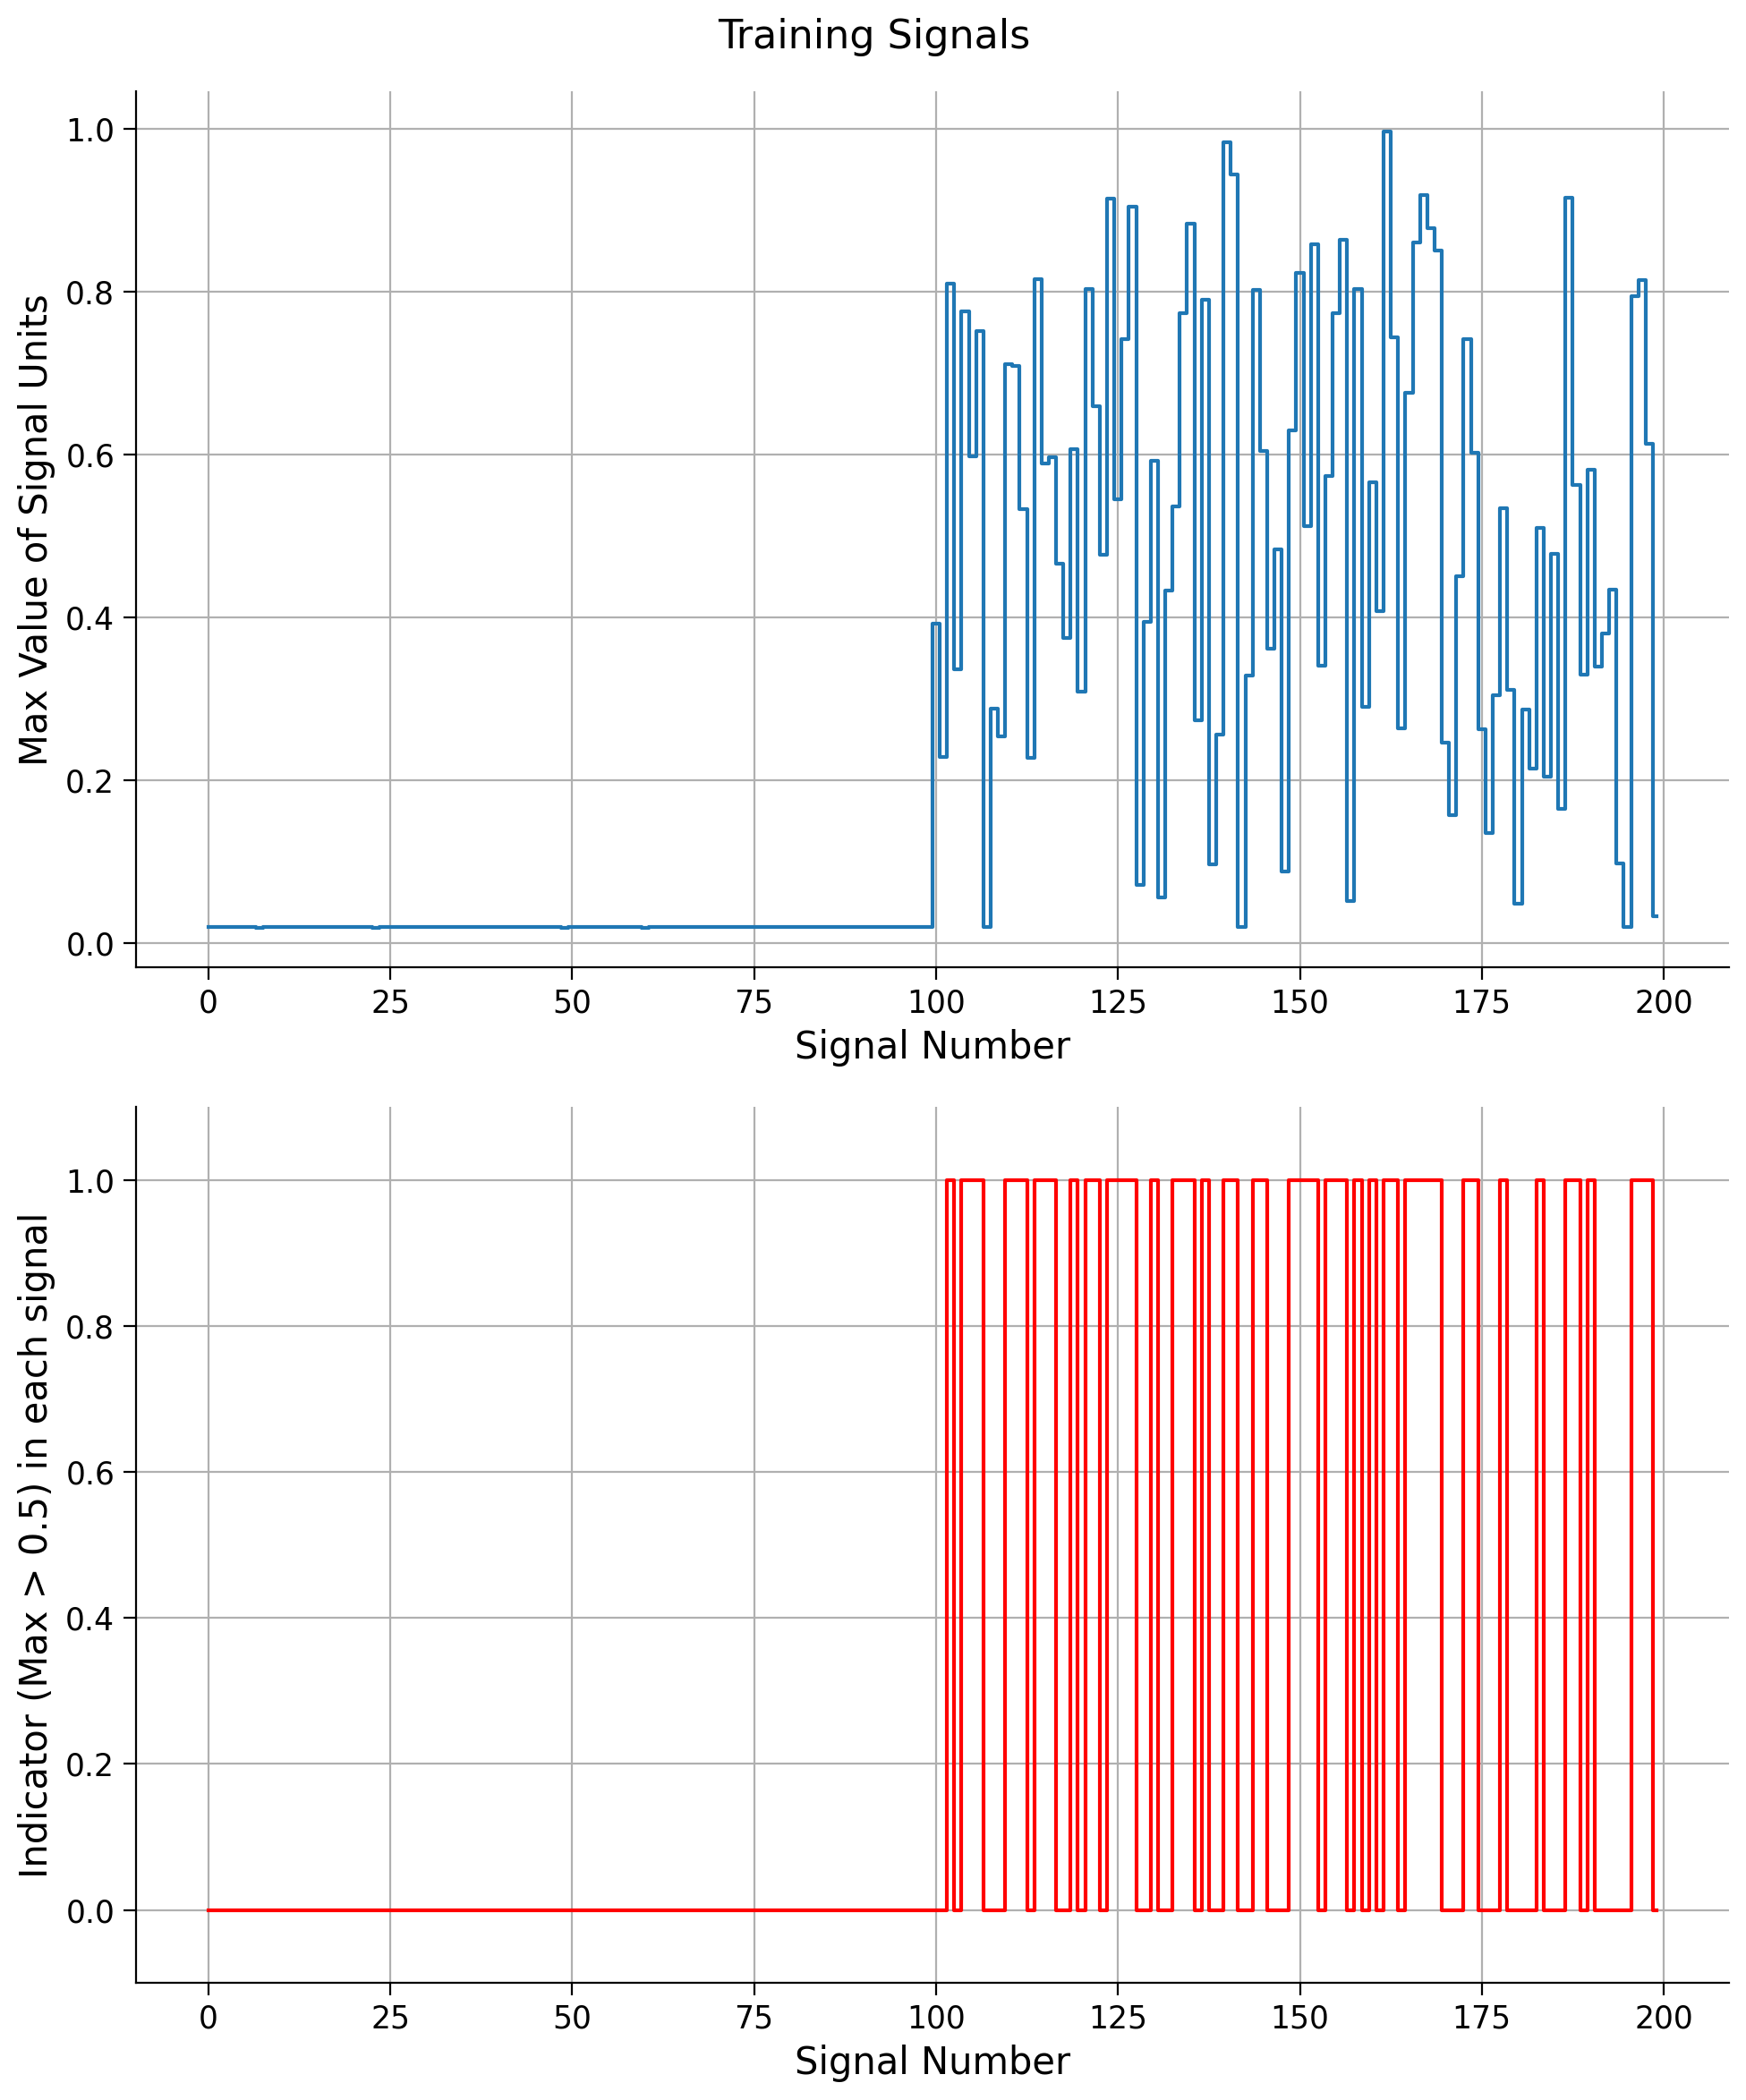

In [19]:
# Visualize the autogenerated data
initialize_global()
patterns_tensor, _ , _, _ = Generate_Patterns(patterns_number, num_units)
plot_signal_max_and_indicator(patterns_tensor)

The pre-training dataset for the network consisted of 200 patterns. These were evenly divided: half were purely noise (with unit activations randomly chosen between 0.0 and 0.02), and the other half represented potential stimuli. In the stimulus patterns, 99 out of 100 units had activations ranging between 0.0 and 0.02, with one unique unit having an activation between 0.0 and 1.0.

### Testing patterns

The network underwent evaluations under three distinct conditions, each modifying the signal-to-noise ratio in a unique way to explore different degrees and types of blindness.

Suprathreshold stimulus condition: here, the network was exposed to the identical set of 200 patterns used during pre-training, testing the network's response to familiar inputs.

Subthreshold stimulus condition (blindsight simulation): this condition aimed to mimic blindsight. It was achieved by introducing a slight noise increment (+0.0012) to every input of the first-order network, barring the one designated as the stimulus. This setup tested the network's ability to discern faint signals amidst noise.

Low vision condition: to simulate low vision, the activation levels of the stimuli were reduced. Unlike the range from 0.0 to 1.0 used in pre-training, the stimuli's activation levels were adjusted to span from 0.0 to 0.3. This condition examined the network's capability to recognize stimuli with diminished intensity.

Now, let's get hands on and plot those auto-generated patterns!

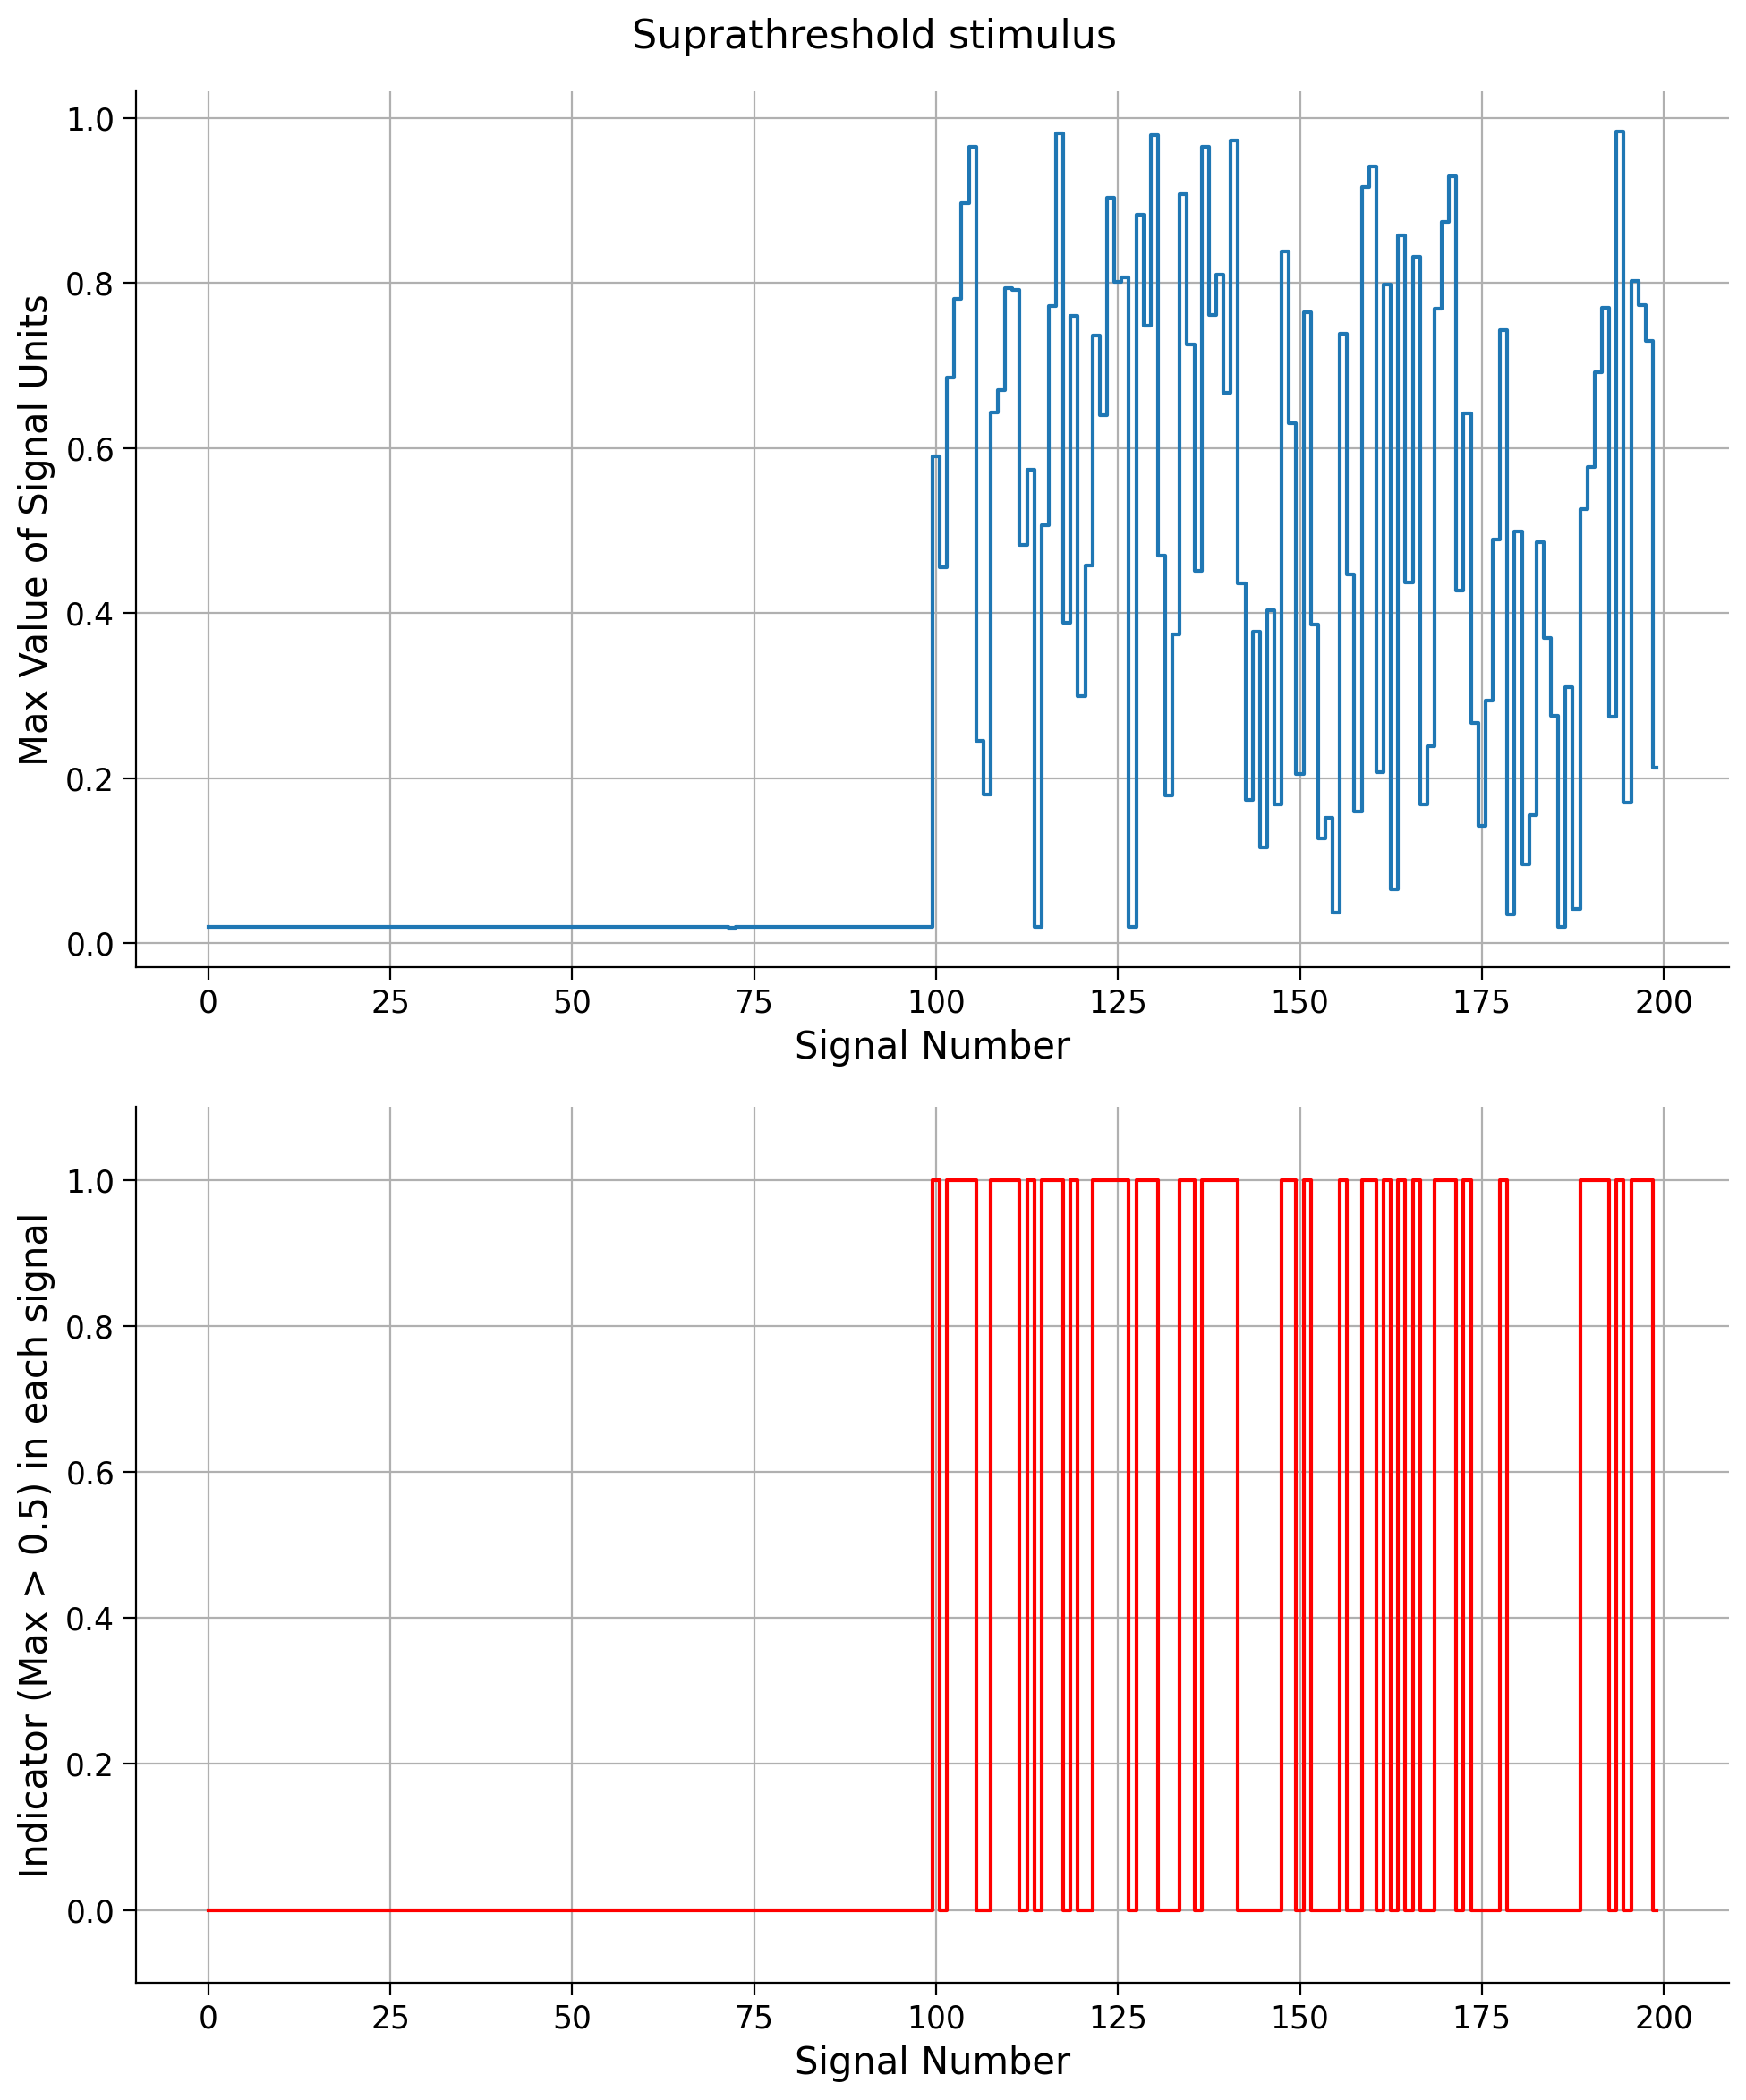

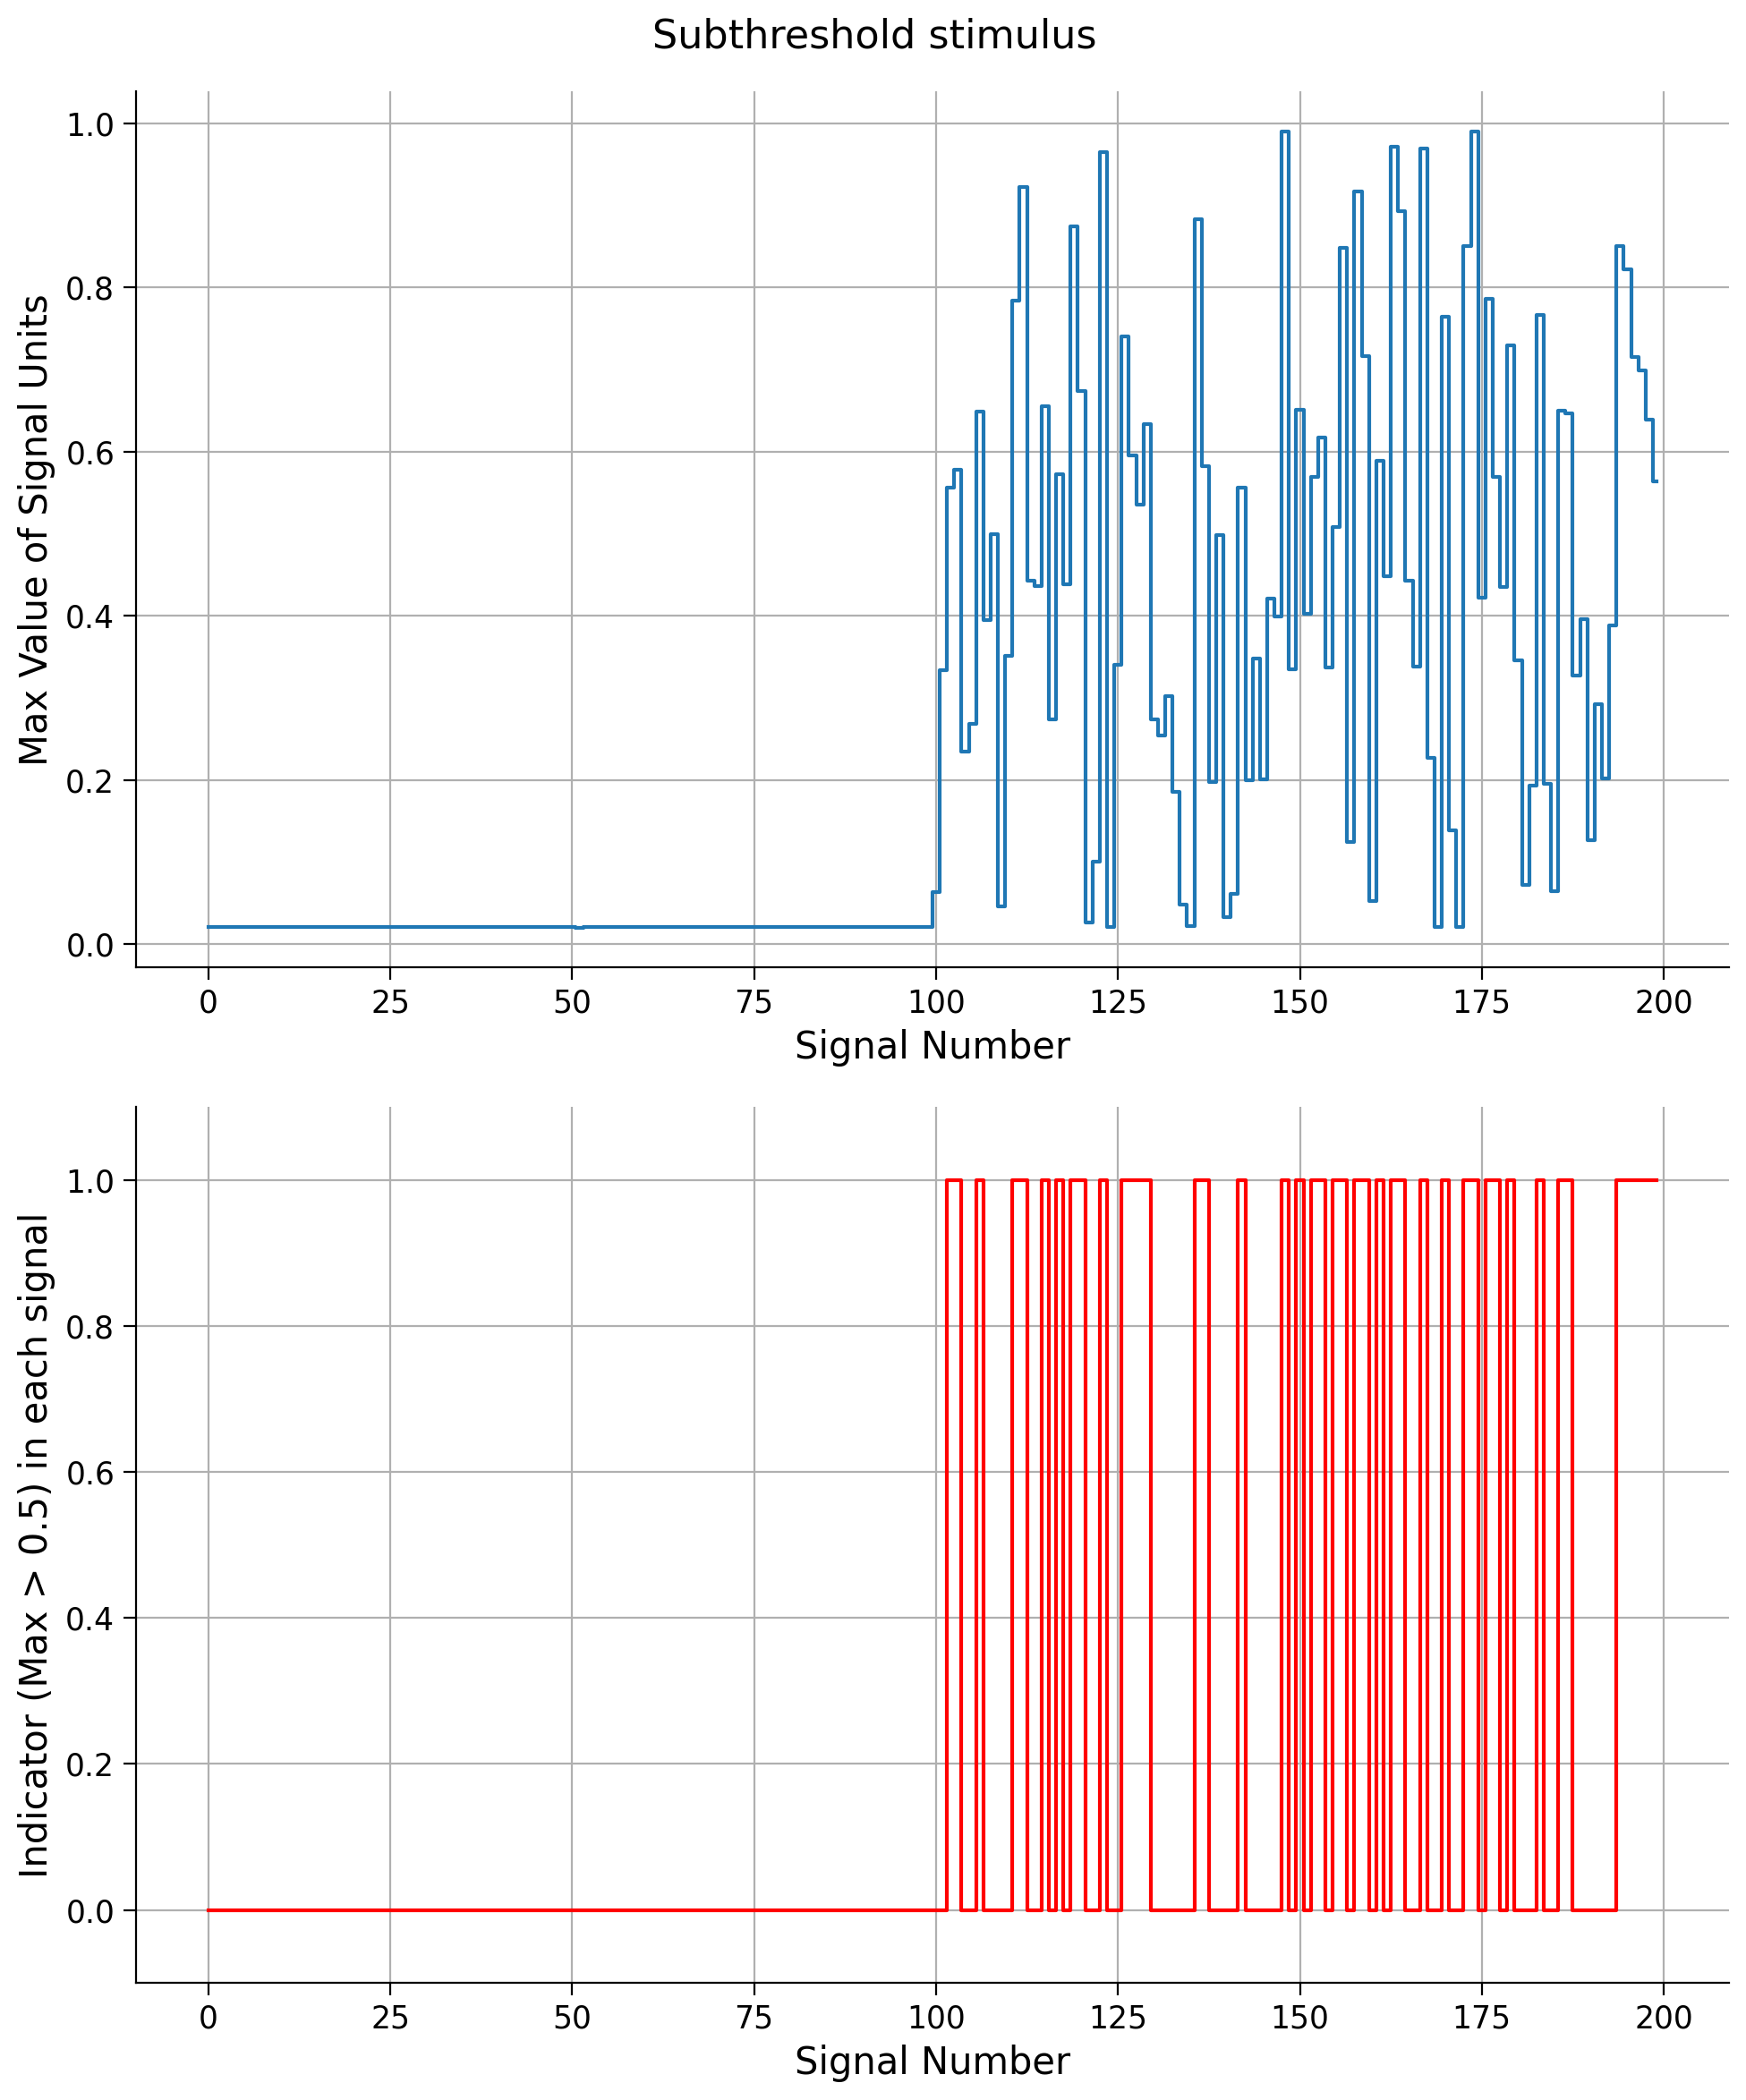

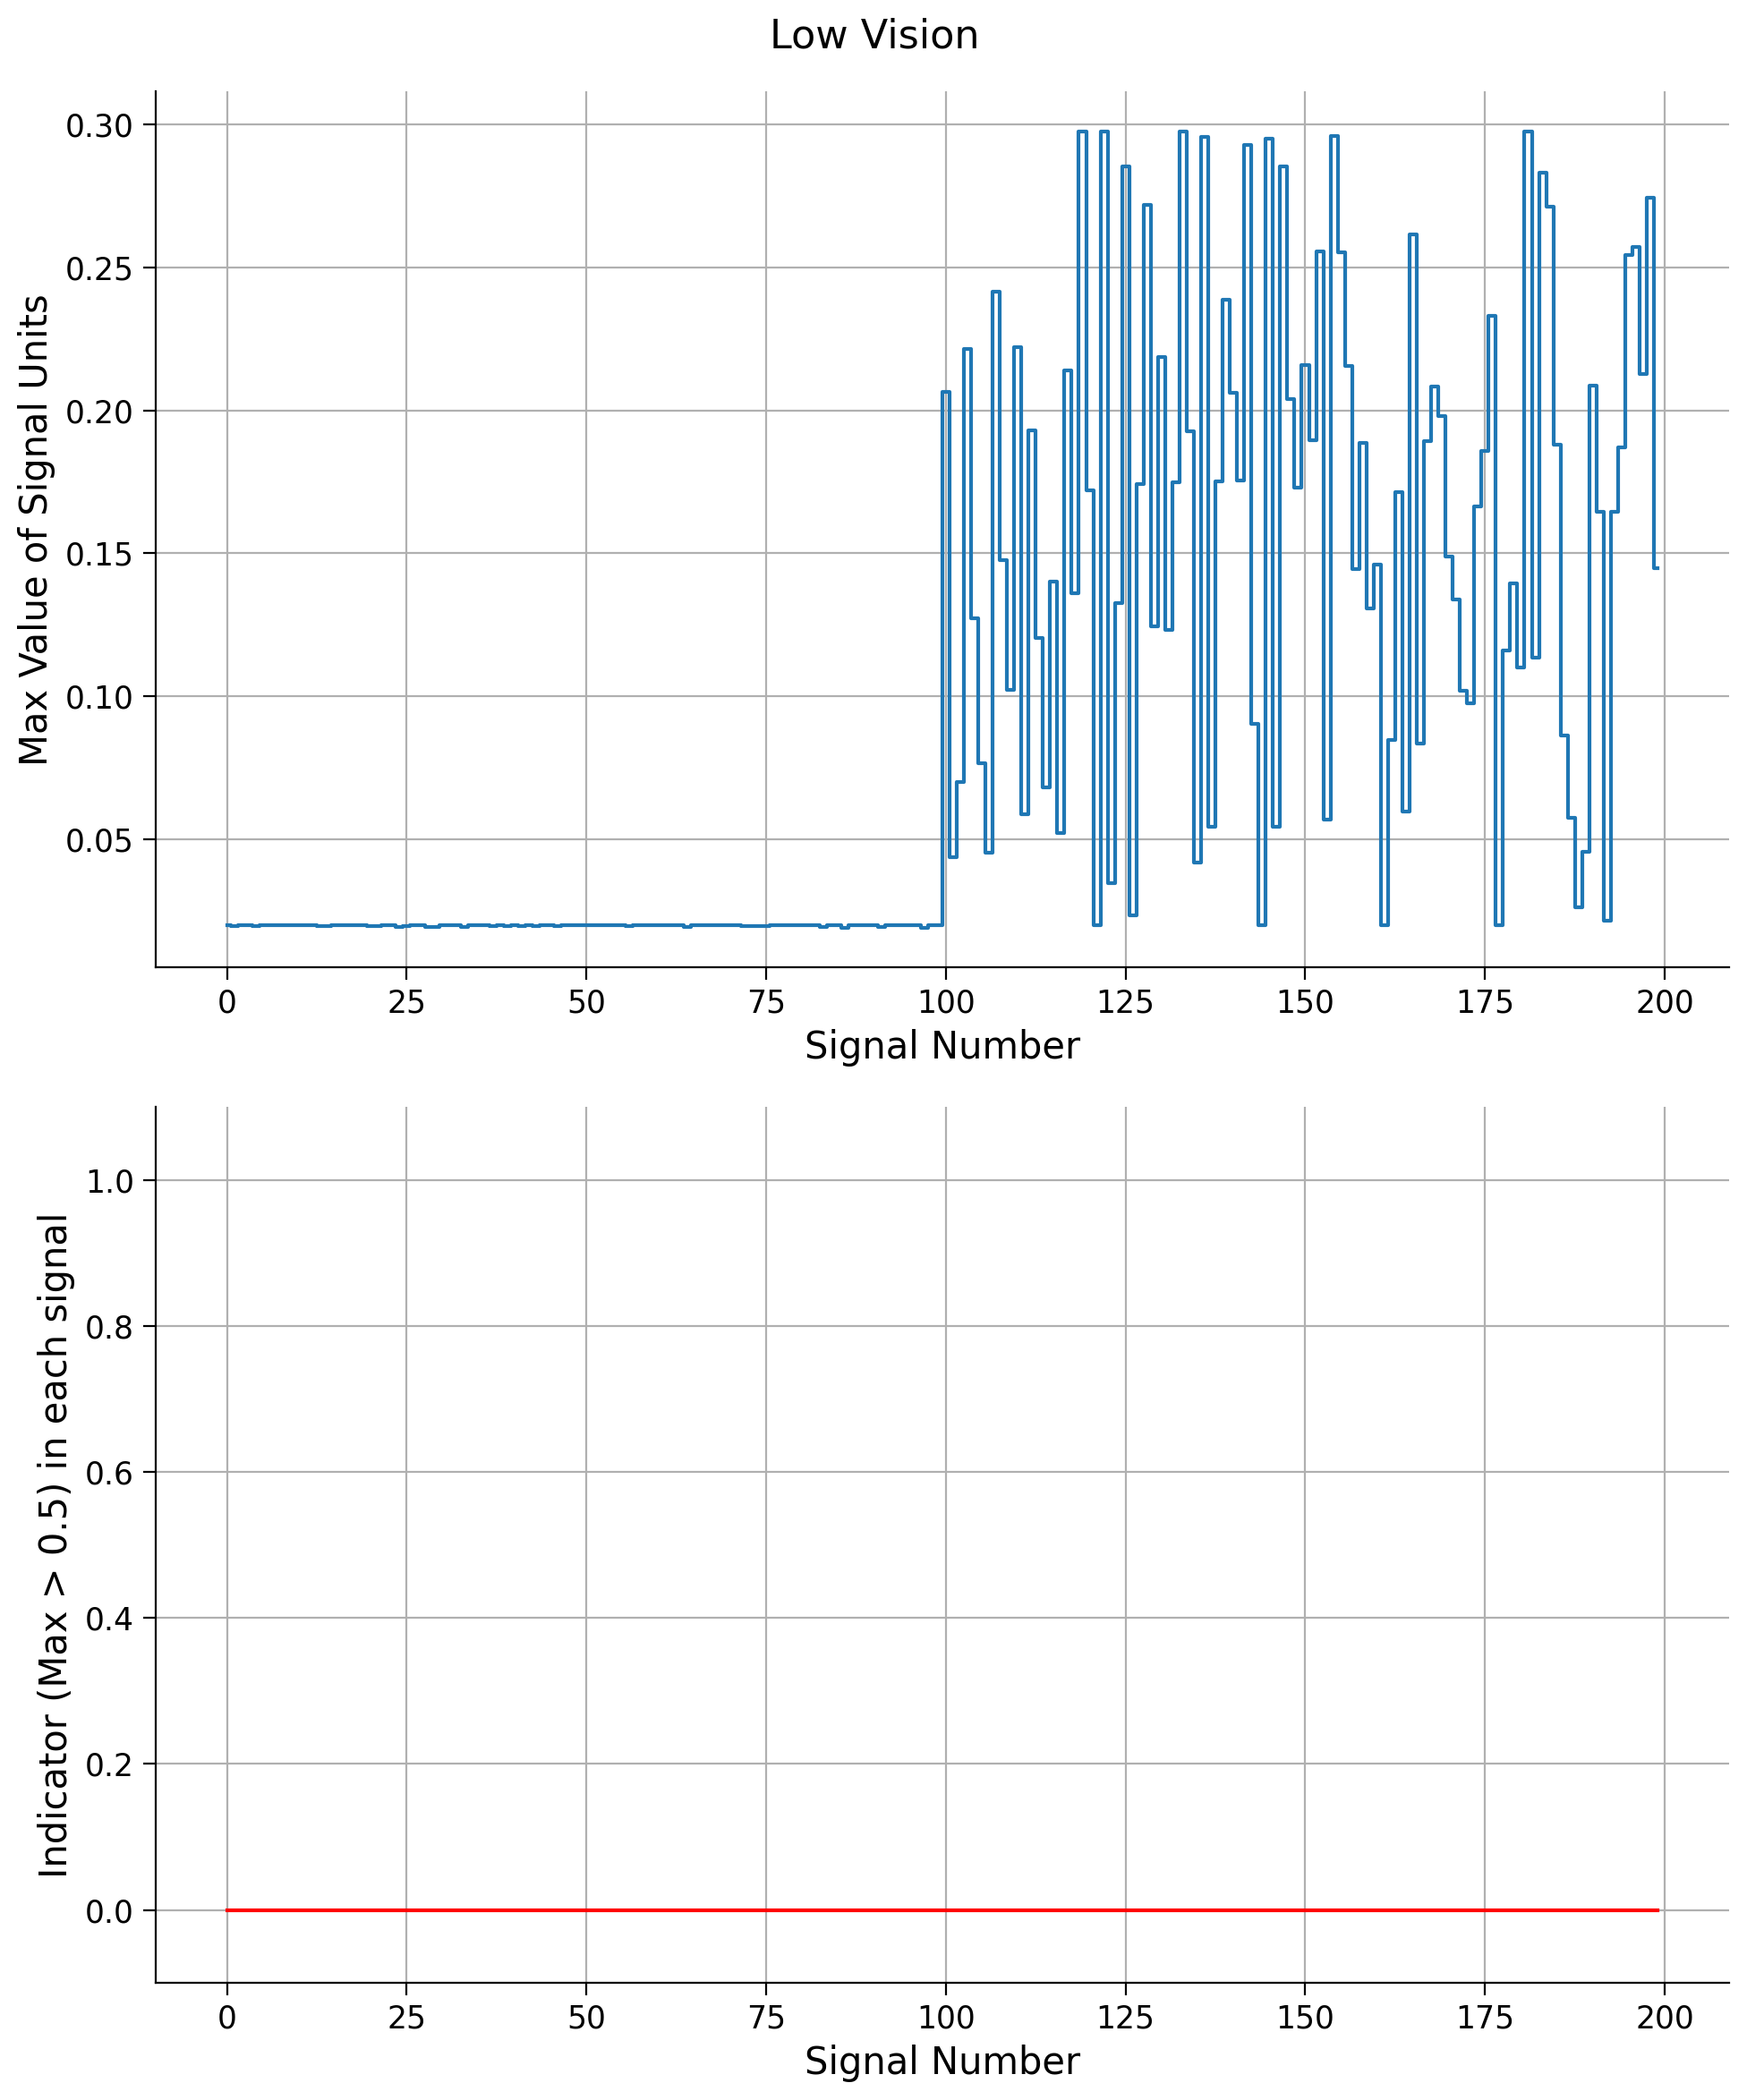

In [20]:
# Compare your results with the patterns generate below
set_1, _ = create_patterns(0)
set_2, _ = create_patterns(1)
set_3, _ = create_patterns(2)

# Plot
plot_signal_max_and_indicator(set_1,"Suprathreshold stimulus")
plot_signal_max_and_indicator(set_2,"Subthreshold stimulus")
plot_signal_max_and_indicator(set_3,"Low Vision")


## Activity 1: Building a nework for a blindsight situation

In this activity, we'll construct a neural network model using our auto-generated dataset, focusing on blindsight scenarios. The model will primarily consist of fully connected layers, establishing a straightforward, first-order network. The aim here is to assess the basic network's performance to later contrast it with the enhancements introduced by a second-order network in the subsequent activity.

### Steps to follow

1. Examine the network architecture: understand the structure of the neural network you're about to work with.
2. Visualize loss metrics: observe and analyze the network's performance during pre-training by visualizing the loss over epochs.
3. Evaluate the model: use the provided code snippets to calculate and interpret the model's accuracy, recall, and F1-score, giving you insight into the network's capabilities.

### Understanding the process

The goal is to gain a thorough comprehension of the network's architecture and to interpret the pre-training results visually. This will provide a clearer picture of the model's potential and limitations.

### Architecture

The network is designed as a backpropagation autoassociator. It features a 100-unit input layer, directly linked to a 60-unit hidden layer, which in turn connects to a 100-unit output layer. Initial connection weights are set within the range of -1.0 to 1.0 for the first-order network. To mitigate overfitting, dropout is employed within the network architecture. The architecture includes a configurable activation function. This flexibility allows for adjustments and tuning in Activity 3, aiming for optimal model performance.

In [21]:
class FirstOrderNetwork(nn.Module):
    def __init__(self, hidden_units, data_factor, use_gelu):
        """
        Initializes the FirstOrderNetwork with specific configurations.

        Parameters:
        - hidden_units (int): The number of units in the hidden layer.
        - data_factor (int): Factor to scale the amount of data processed. 
                             A factor of 1 indicates the default data amount, 
                             while 10 indicates 10 times the default amount.
        - use_gelu (bool): Flag to use GELU (True) or ReLU (False) as the activation function.
        """
        super(FirstOrderNetwork, self).__init__()

        # Define the encoder, hidden, and decoder layers with specified units
        self.encoder = nn.Linear(100, hidden_units)
        self.hidden = nn.Linear(hidden_units, hidden_units)
        self.decoder = nn.Linear(hidden_units, 100)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.3)

        # Temperature parameter for activation sharpness control
        self.temperature = 1.0

        # Set the data factor
        self.data_factor = data_factor

        # Choose the activation function based on the use_gelu flag
        self.activation = nn.GELU() if use_gelu else nn.ReLU()

        # Other activation functions for various purposes
        self.sigmoid = torch.sigmoid
        self.softmax = nn.Softmax(dim=1)
        self.tanh = torch.tanh

        # Initialize network weights
        self.initialize_weights()

    def initialize_weights(self):
        """Initializes weights of the encoder, hidden, and decoder layers uniformly."""
        init.uniform_(self.encoder.weight, -1.0, 1.0)
        init.uniform_(self.hidden.weight, -1.0, 1.0)
        init.uniform_(self.decoder.weight, -1.0, 1.0)

    def forward(self, x):
        """
        Defines the forward pass through the network.

        Parameters:
        - x (Tensor): The input tensor to the network.

        Returns:
        - Tensor: The output of the network after passing through the layers and activations.
        """
        # Encoder step with dropout and sigmoid activation
        x = self.dropout(self.sigmoid(self.encoder(x) / self.temperature))
        
        # Hidden layer step with dropout and sigmoid activation
        x = self.dropout(self.sigmoid(self.hidden(x) / self.temperature))
        
        # Decoder step with dropout and sigmoid activation
        output = self.dropout(self.sigmoid(self.decoder(x) / self.temperature))

        # Adjust output based on a threshold
        output = torch.where(output > 0.5, output + 0.12, output)

        return output

### First order network training

For now, we will train the first order network only.

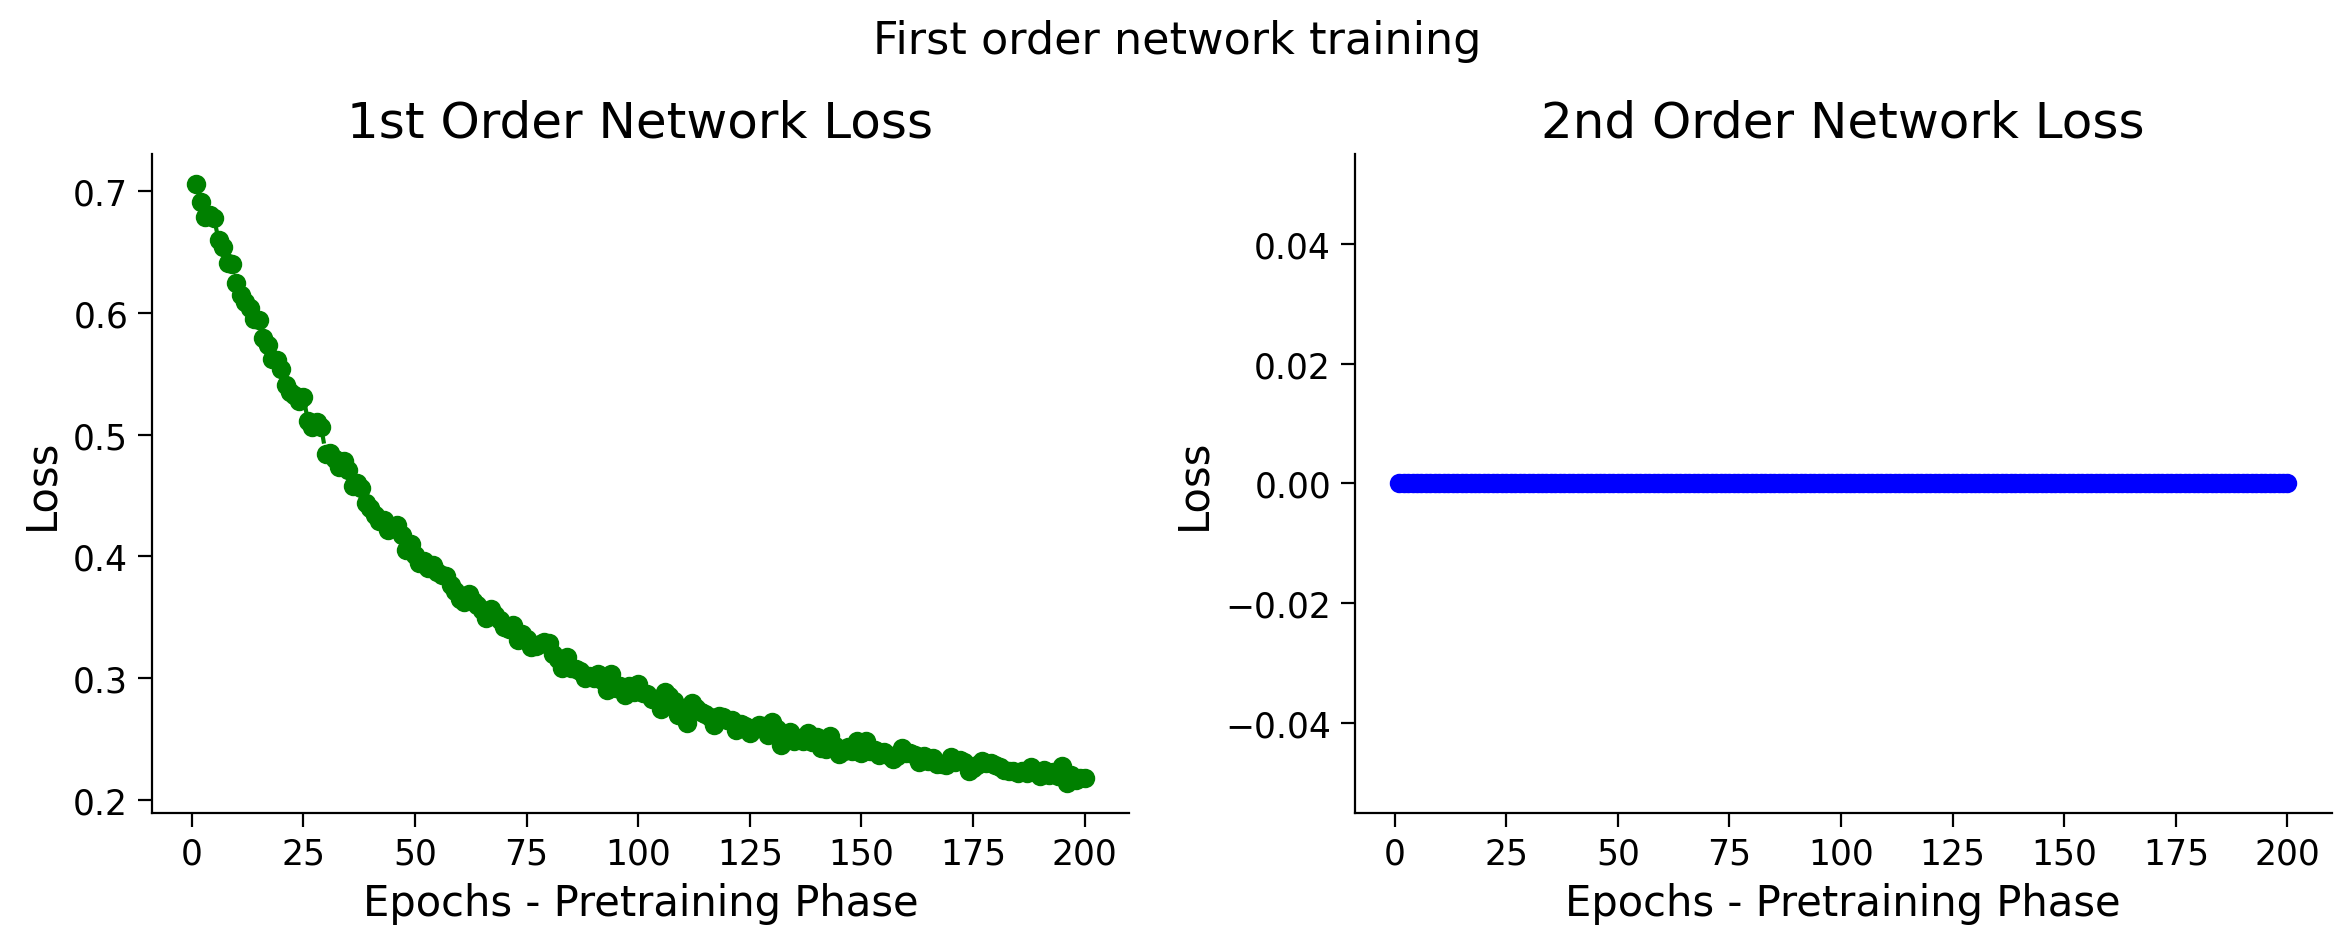

In [22]:
# Define the architecture, optimizers, loss functions, and schedulers for pre training
hidden=60
factor=1
gelu=False
gam=0.99
stepsize=1

initialize_global()

# Networks instantiation
first_order_network = FirstOrderNetwork(hidden,factor,gelu).to(device)
second_order_network = SecondOrderNetwork(gelu).to(device) # We define it, but won't use it until activity 3

# Loss function
criterion_1 = nn.MSELoss()

# Optimizer
optimizer_1 = optim.SGD(first_order_network.parameters(), lr=learning_rate_1, momentum=momentum)

# Learning rate schedulers
scheduler_1 = StepLR(optimizer_1, step_size=stepsize, gamma=gam)

# Training loop
for epoch in range(n_epochs):
    # Generate training patterns and targets for each epoch.
    patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

    # Forward pass through the first-order network
    output_first_order = first_order_network(patterns_tensor)

    # Skip computations for the second-order network
    with torch.no_grad():
        # Potentially forward pass through the second-order network without tracking gradients
        output_second_order = second_order_network(patterns_tensor, output_first_order)

    # Calculate the loss for the first-order network (accuracy of stimulus representation)
    loss_1 = criterion_1(output_first_order, stim_present_tensor)

    # Backpropagate the first-order network's loss
    loss_1.backward()

    # Update first-order network weights
    optimizer_1.step()

    # Reset first-order optimizer gradients to zero for the next iteration
    optimizer_1.zero_grad()

    # Update the first-order scheduler
    scheduler_1.step()

    epoch_1_order[epoch] = loss_1.item()

# Plot training loss curve
pre_train_plots(epoch_1_order, epoch_2_order, "First order network training")


### Testing under 3 blindsight conditions

We will now use the testing auto-generated datasets from activity 1 to test the network's performance.

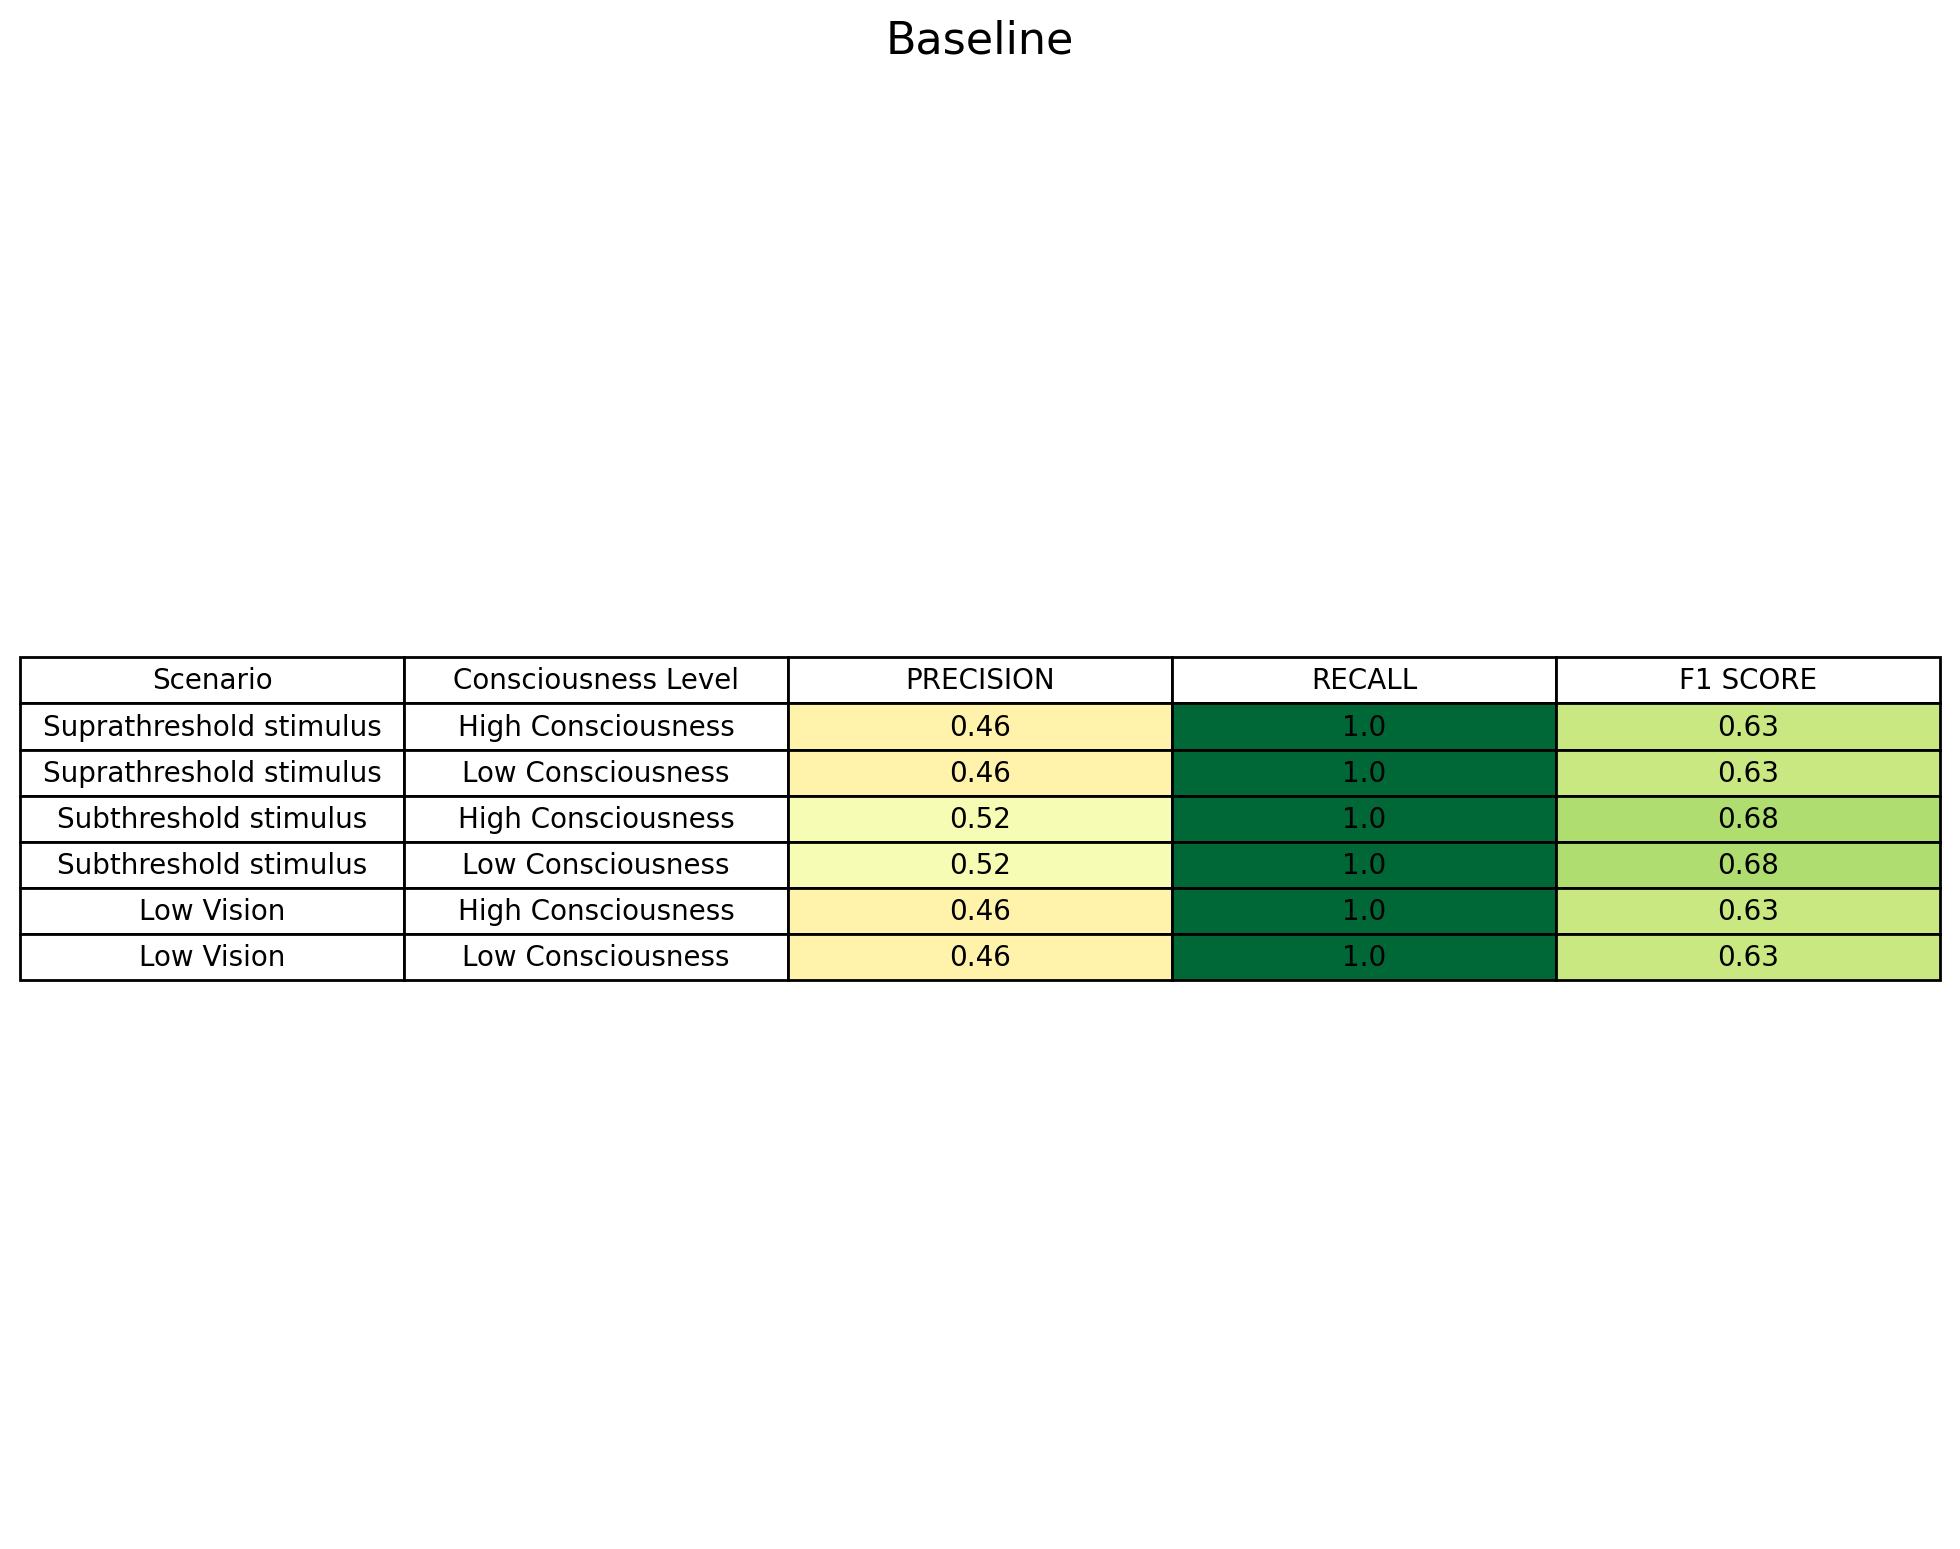

In [23]:
# Prepare networks for testing by calling the configuration function
Testing_patterns, n_samples, loaded_model, loaded_model_2 = config_training(first_order_network, second_order_network, hidden, factor, gelu)

# Perform testing using the defined function and plot the results
f1_scores_high_wager, f1_scores_low_wager, results_for_plotting = testing(Testing_patterns, n_samples, loaded_model, loaded_model_2)

# Assuming plot_testing is defined, call it to display results
plot_testing(results_for_plotting, "Baseline")

## Activity 2: Developing a Second-Order Network

In this activity, we transition to constructing a more complex model: a second-order network. This network builds upon the foundational first-order network by introducing a meta-cognitive layer that evaluates the first-order network's predictions. The primary novelty here is the introduction of a wagering mechanism, where the network "bets" on its confidence level in its predictions.

### Objective

Your mission involves expanding the model architecture to incorporate second-order functionalities. This includes understanding and coding the mechanisms behind a second-order network, followed by evaluating its performance through training loss visualization and testing with provided code snippets. You're also encouraged to explore model fine-tuning to optimize performance.

### Steps for completion

1. Architectural development: grasp the underlying principles of a second-order network and complete the architectural code.
2. Performance evaluation: visualize training losses and test the model using provided code, assessing its initial performance.
3. Model fine-tuning: leveraging the provided training function, experiment with fine-tuning the model to enhance its accuracy and efficiency.

### Network architecture overview

The second-order network is structured as a feedforward backpropagation network.

- Input Layer: comprises a 100-unit comparison matrix. This matrix quantifies the discrepancy between each corresponding pair of input and output units from the first-order network. For example, if an input unit and its corresponding output unit have activations of 0.6 and 0.7, respectively, the comparison unit's activation would be -0.1. This setup essentially encodes the prediction error of the first-order network's outputs as an input pattern for the second-order network.
- Output Layer: consists of two units representing "high" and "low" wagers, indicating the network's confidence in its predictions. The initial weights for these output units range between 0.0 and 0.1.
- Comparator Weights: set to 1.0 for connections from the first-order input layer to the comparison matrix, and -1.0 for connections from the first-order output layer. This configuration emphasizes the differential error as a critical input for the second-order decision-making process.

### Understanding second-order mechanisms

The second-order network's novel approach uses the error generated by the first-order network as a direct input for making decisions—specifically, wagering on the confidence of its outputs. This methodology reflects a meta-cognitive layer of processing, akin to evaluating one's confidence in their answers or predictions.

### Fine-tuning insights

Fine-tuning involves adjusting various model parameters, such as learning rates, the number of epochs, or even the architecture itself (e.g., adding layers, changing activation functions) to achieve better performance. The goal is to improve the network's prediction accuracy and confidence wagering, thereby making it more adept at tasks resembling the blindsight condition simulation.

By exploring these adjustments, you can optimize the network's functionality, making it a powerful tool for understanding and simulating complex cognitive phenomena like blindsight.

In [24]:
class SecondOrderNetwork(nn.Module):
    def __init__(self, use_gelu):
        super(SecondOrderNetwork, self).__init__()
        # Define a linear layer for comparing the difference between input and output of the first-order network
        self.comparison_layer = nn.Linear(100, 100)
        
        # Linear layer for determining wagers, mapping from 100 features to a single output
        self.wager = nn.Linear(100, 1)
        
        # Dropout layer to prevent overfitting by randomly setting input units to 0 with a probability of 0.3 during training
        self.dropout = nn.Dropout(0.3)
        
        # Select activation function based on the `use_gelu` flag
        self.activation = torch.nn.GELU() if use_gelu else torch.relu
        
        # Additional activation functions for potential use in network operations
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax for multi-class classification problems
        self.tanh = torch.tanh
        
        # Initialize the weights of the network
        self._init_weights()

    def _init_weights(self):
        # Uniformly initialize weights for the comparison and wager layers
        init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):
        # Calculate the difference between the first-order input and output
        comparison_matrix = first_order_input - first_order_output
        
        # Pass the difference through the comparison layer and apply the chosen activation function
        comparison_out = self.comparison_layer(comparison_matrix)
        
        # Calculate the wager value, applying dropout and sigmoid activation to the output of the wager layer
        wager = self.dropout(self.sigmoid(self.wager(comparison_out)))
        
        return wager


/home/samuele/virtualenvs/neuroaienv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([200, 2])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


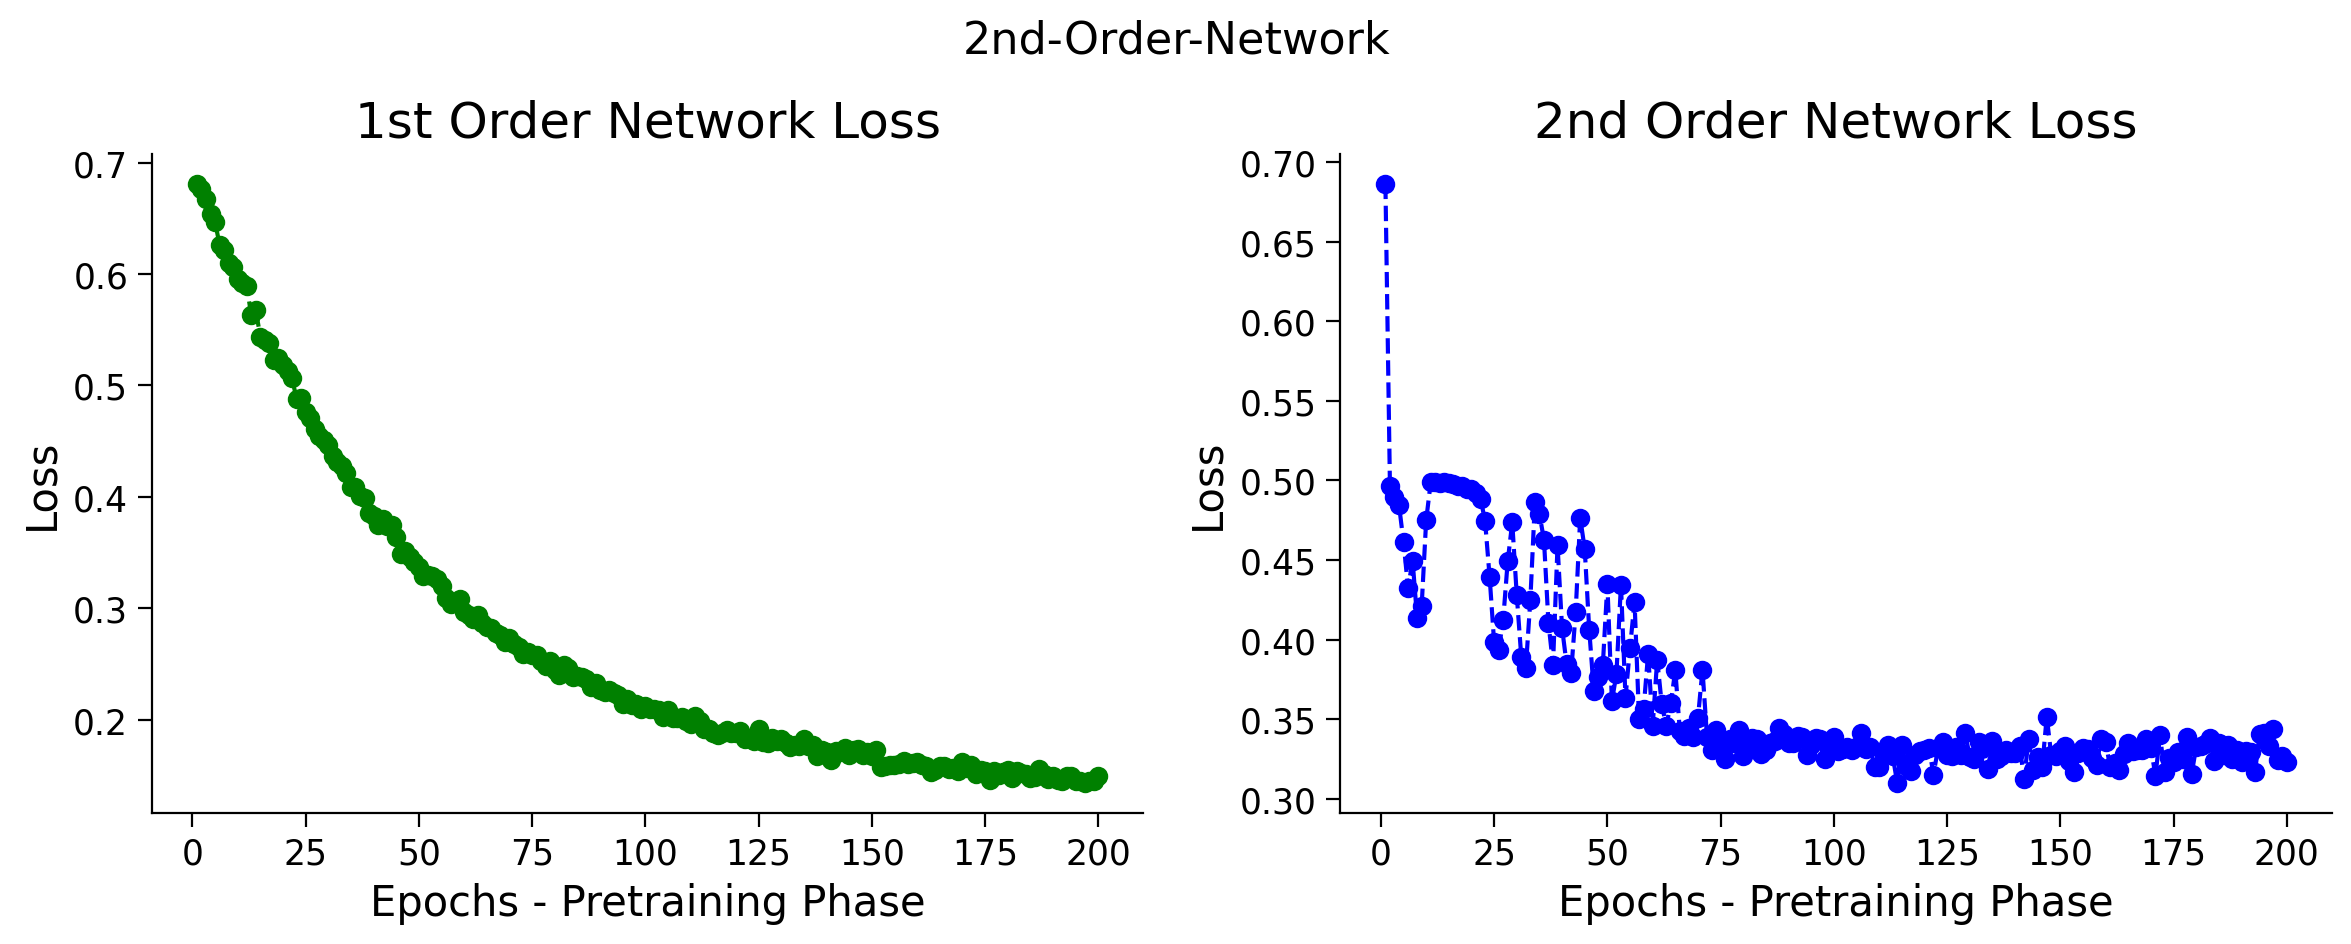

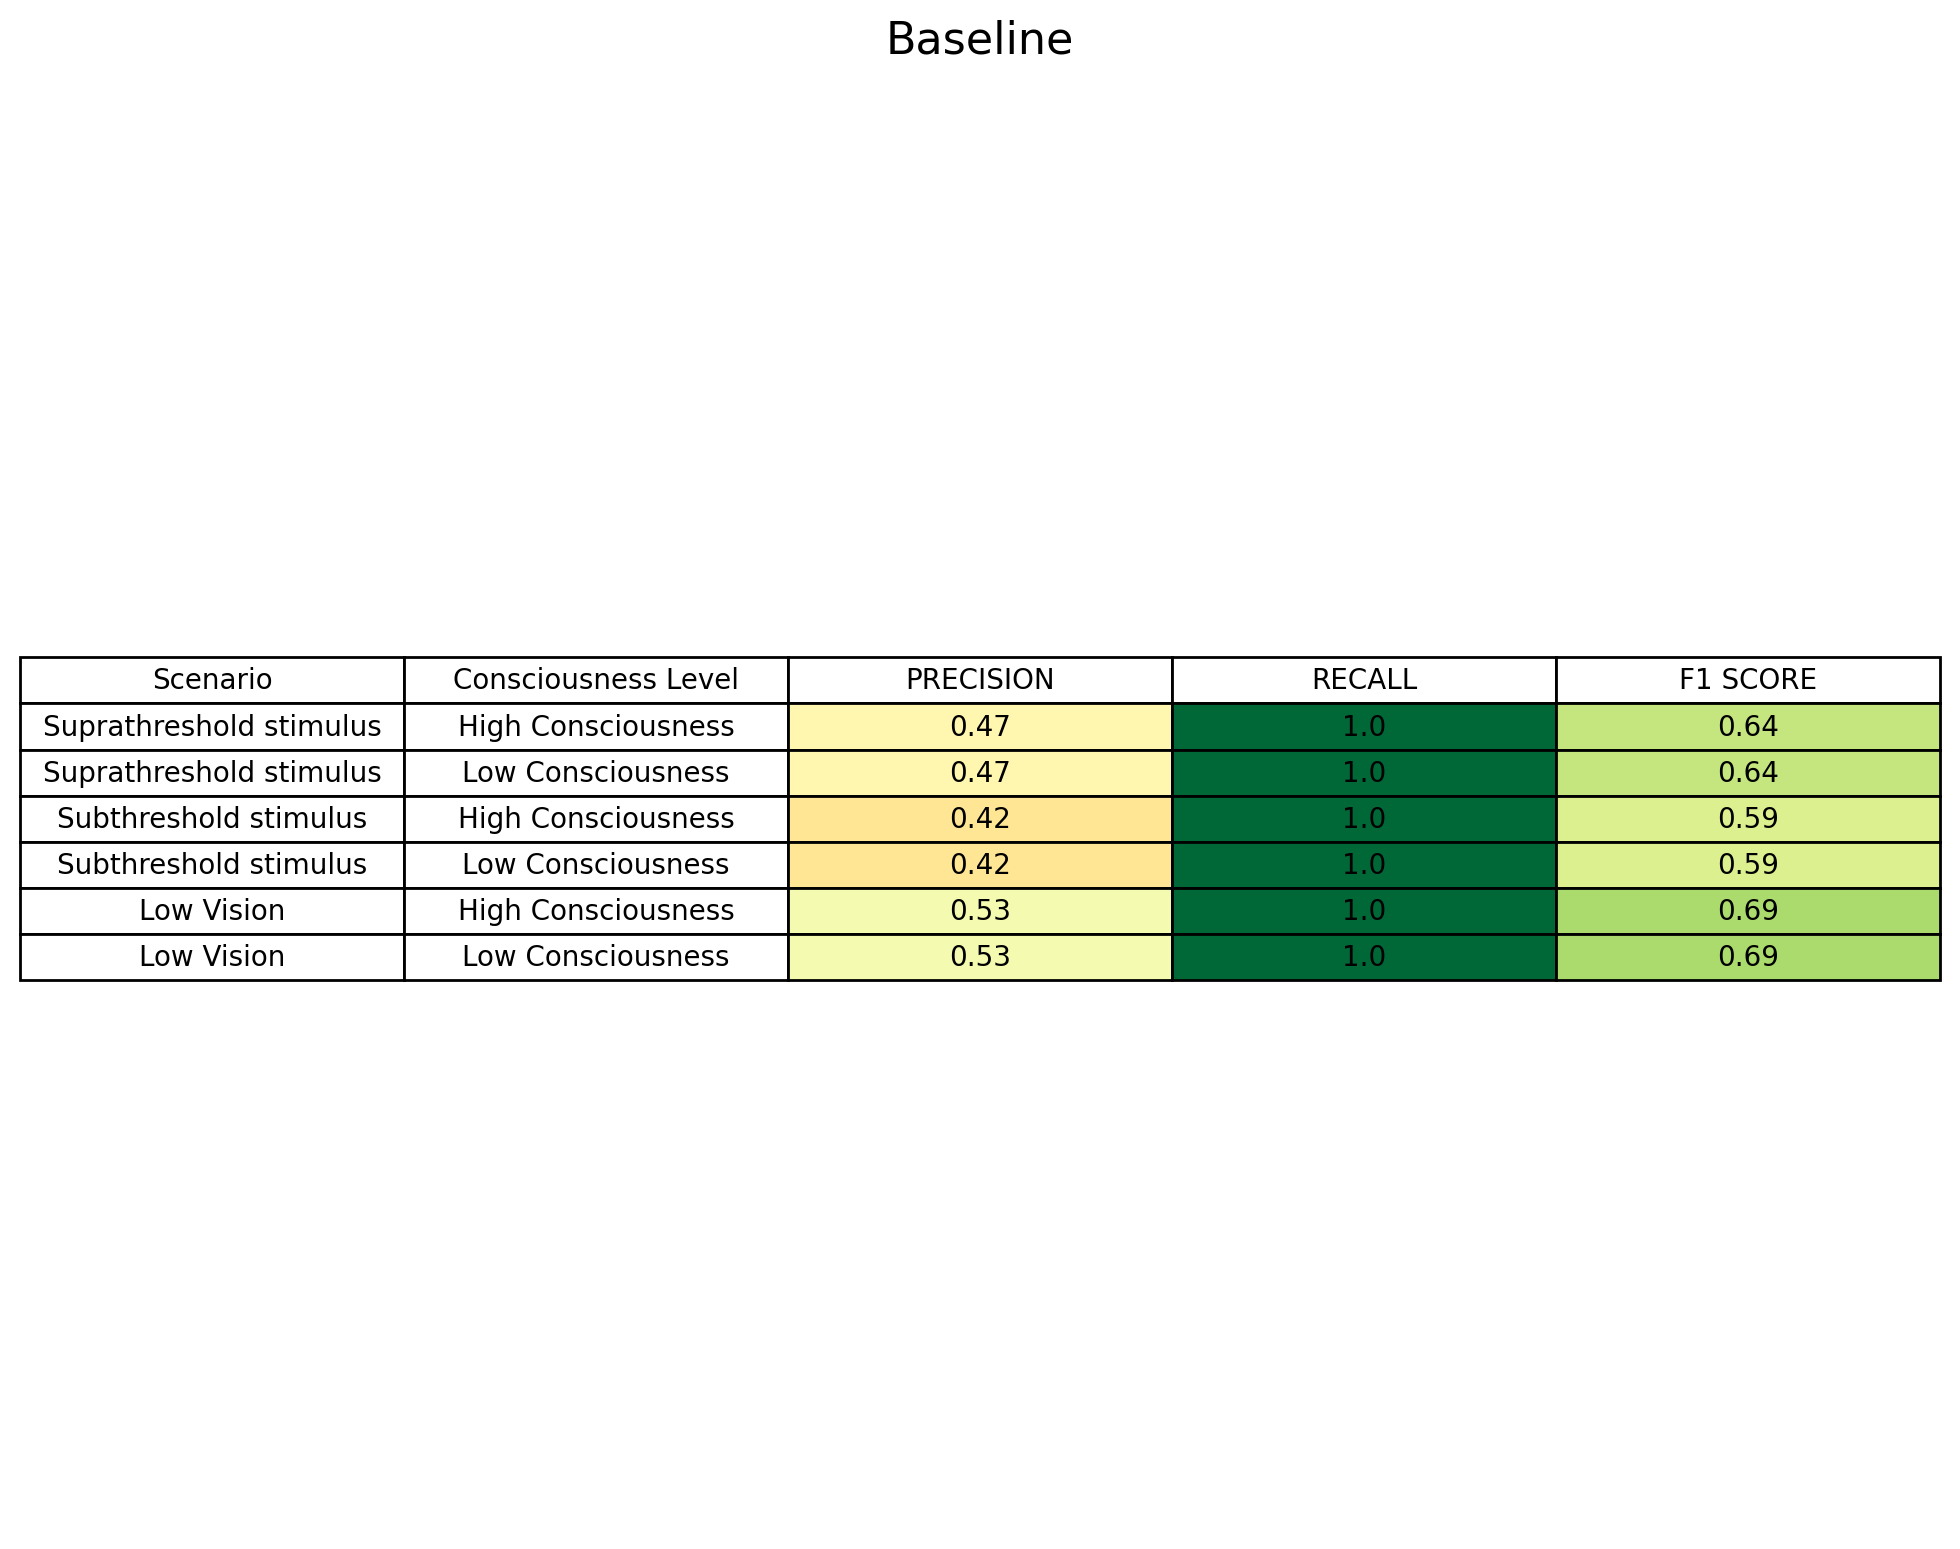

In [25]:
def pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, factor, meta):
    """
    Conducts pre-training for first-order and second-order networks.
    
    Parameters:
    - first_order_network (torch.nn.Module): Network for basic input-output mapping.
    - second_order_network (torch.nn.Module): Network for decision-making based on the first network's output.
    - criterion_1, criterion_2 (torch.nn): Loss functions for the respective networks.
    - optimizer_1, optimizer_2 (torch.optim): Optimizers for the respective networks.
    - scheduler_1, scheduler_2 (torch.optim.lr_scheduler): Schedulers for learning rate adjustment.
    - factor (float): Parameter influencing data augmentation or pattern generation.
    - meta (bool): Flag indicating the use of meta-learning strategies.
    
    Returns:
    Tuple containing updated networks and epoch-wise loss records.
    """
    for epoch in range(n_epochs):
        # Generate training patterns and targets for each epoch
        patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

        # Forward pass through the first-order network
        output_first_order = first_order_network(patterns_tensor)

        optimizer_1.zero_grad()

        # Conditionally execute the second-order network pass and related operations
        if meta:
            optimizer_2.zero_grad()

            # Forward pass through the second-order network with inputs from the first-order network
            output_second_order = second_order_network(patterns_tensor, output_first_order)

            # Calculate the loss for the second-order network (wagering decision based on comparison)
            loss_2 = criterion_2(output_second_order, order_2_tensor)

            # Backpropagate the second-order network's loss
            loss_2.backward(retain_graph=True)  # Allows further backpropagation for loss_1 after loss_2

            # Update second-order network weights
            optimizer_2.step()

            epoch_2_order[epoch] = loss_2.item()
        else:
            # Skip computations for the second-order network
            with torch.no_grad():
                # Potentially forward pass through the second-order network without tracking gradients
                output_second_order = second_order_network(patterns_tensor, output_first_order)

        # Calculate the loss for the first-order network (accuracy of stimulus representation)
        loss_1 = criterion_1(output_first_order, stim_present_tensor)

        # Backpropagate the first-order network's loss
        loss_1.backward(retain_graph=True)

        # Update first-order network weights
        optimizer_1.step()

        # Reset first-order optimizer gradients to zero for the next iteration

        # Update the first-order scheduler
        scheduler_1.step()

        # Update the second-order scheduler
        scheduler_2.step()

        epoch_1_order[epoch] = loss_1.item()

    return first_order_network, second_order_network, epoch_1_order, epoch_2_order

# Hyperparameters
hidden=60
factor=1
gelu=False
gam=0.99
stepsize=1
meta=True

# Initialize any global variables or settings, potentially for random seed setting or environment setup
initialize_global()

# Prepare networks, loss functions, optimizers, and schedulers for pre-training
first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2 = prepare_pre_training(hidden, factor, gelu, stepsize, gam)

# Conduct pre-training for both the first-order and second-order networks
first_order_network_pre, second_order_network_pre, epoch_1_order, epoch_2_order = pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, factor, meta)

# Plot the training progress of both networks to visualize performance and learning trends
pre_train_plots(epoch_1_order, epoch_2_order, "2nd-Order-Network")

# Configuration step for the main training phase or evaluation
Testing_patterns, n_samples, loaded_model, loaded_model_2 = config_training(first_order_network_pre, second_order_network_pre, hidden, factor, gelu)

# Perform testing of the trained models on a separate dataset to evaluate performance
f1_scores_high_wager, f1_scores_low_wager, results_for_plotting = testing(Testing_patterns, n_samples, loaded_model, loaded_model_2)

# Visualize the testing results, comparing the model performance against a baseline to assess improvements
plot_testing(results_for_plotting, "Baseline")

## Discussion point

Let's dive into the outcomes!

- Did you notice any variations between the two models?
- Can you explain how these differences influenced the performance?
- What role does a second-order network play, and in which situations would it be more effective?

---
# Section 5: HOSS model

In this Section we will combine elements of the previous sections to illustrate an alternative perspective on the origins of conscious awareness in neural systems. This perspective is provided by higher-order theory, and the core idea is that consciousness is enabled by the monitoring of first-order information processing, rather than the global broadcast. This perspective shares with global workspace architectures the need for a “global” monitor of multiple first-order modules. It also builds on the previous section that highlights the important of a second-order network for monitoring first-order processing to explain blindsight.

The following function is designed for inference within a simplified Bayesian framework, specifically tailored for assessing perceptual states based on observed data. It computes the posterior probabilities of these states and the Kullback-Leibler (KL) divergence between the posterior and prior distributions. This function operates under a model that assumes a flat (or single-layer) Bayesian network, focusing directly on the relationship between perceptual states and observed data. 

In [26]:
def HOSS_evaluate_flat(X, mu, Sigma, Wprior):
    """
    Perform inference on a 2D Bayes net for asymmetric inference on presence vs. absence.
    
    Parameters:
    X - Observed data
    mu - Means for each perceptual state
    Sigma - Covariance matrix
    Wprior - Prior probabilities of perceptual states
    
    #Returns:
    post_W - Posterior probabilities of perceptual states
    KL_W - Kullback-Leibler divergence from posterior to prior
    """
    # Prior on perceptual states W
    p_W = Wprior

    # Compute likelihood of observed X for each possible W (P(X|W))
    log_lik_X_W = np.array([np.log(multivariate_normal.pdf(X, mean=mu[m], cov=Sigma)) for m in range(mu.shape[0])])
    
    # Renormalize to get P(X|W)
    log_p_X_W = log_lik_X_W - logsumexp(log_lik_X_W)

    # Posterior over W (P(W|X=x))
    log_post_W = log_p_X_W + np.log(p_W)
    log_post_W = log_post_W - logsumexp(log_post_W)  # Normalize
    post_W = np.exp(log_post_W)

    # KL divergences
    KL_W = np.sum(post_W * (np.log(post_W) - np.log(p_W)))

    return post_W, KL_W

## Make our stimulus space

The model we are using is grounded in classical "signal detection theory", or SDT for short. SDT is in turn a special case of a Bayesian generative model, in which an arbitrary "evidence" value is drawn from an unknown distribution, and the task of the observer is to infer which distribution this evidence came from.

Let's imagine we have two categories, A and B - for instance, left- and right-tilted visual stimuli. 
The sensory "evidence" can be written as 2D vector, where the first element is evidence for A, and the second element evidence for B:

In [27]:
# Creating the array X with strong evidence for A and weak evidence for B
X = np.array([1.5, 0])

The origin (0,0) represents low activation of both features, consistent with no stimulus (or noise) being presented. Comparing how the model handles inference on stimulus presence vs. absence - detecting, vs. not detecting a stimulus - allows us to capture the classical conscious vs. unconscious contrast in consciousness science.

Let's start by creating our space, and placing three Gaussian distributions on the space that represent the likelihood of observing a pair of features given each of three stimulus classes: leftward tilt (w1), rightward tilt (w2) and noise/nothing (w0).

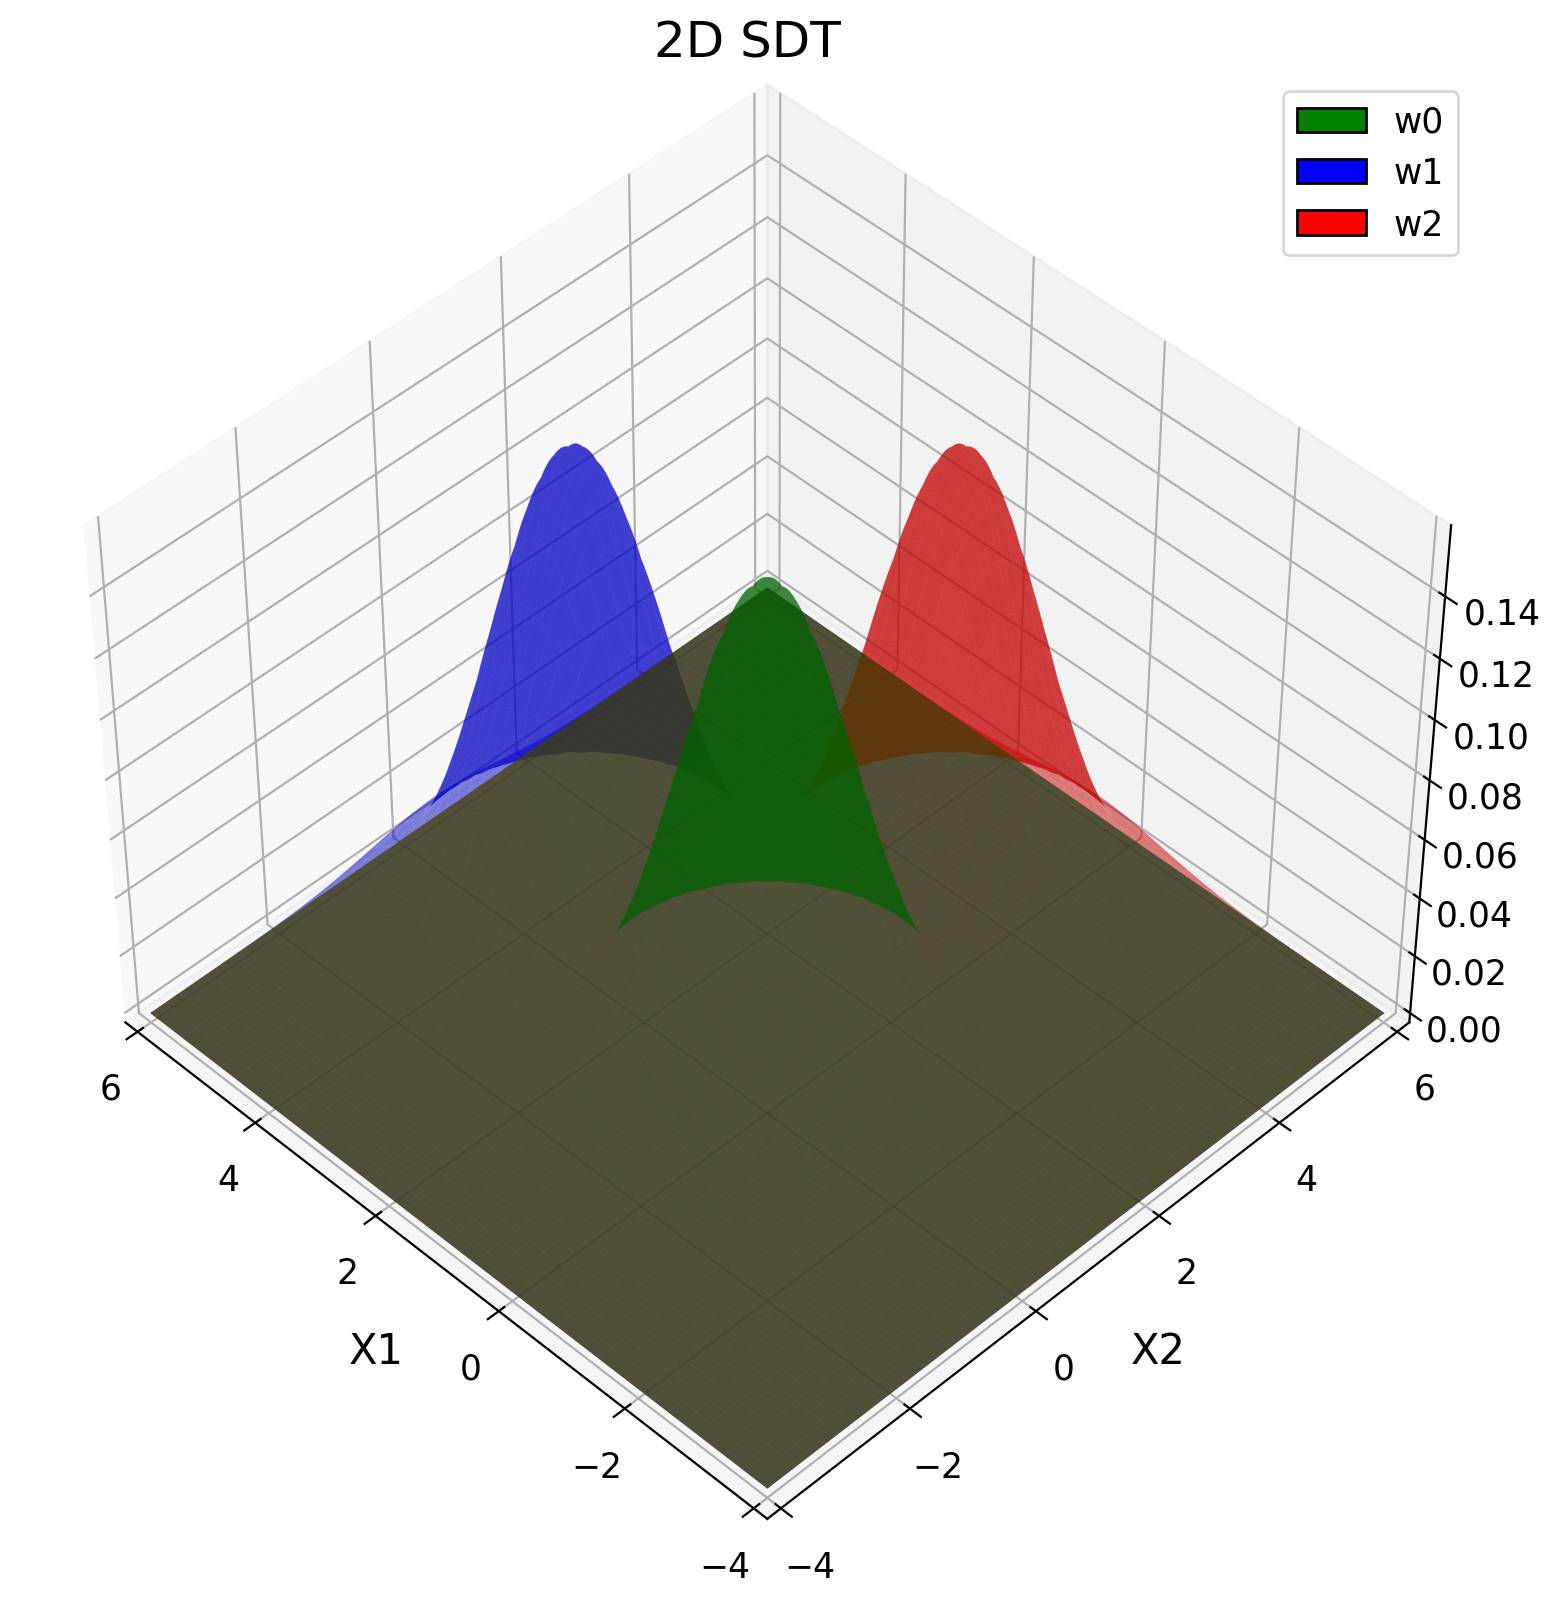

In [28]:
# Define the grid
xgrid = np.arange(-4, 6.02, 0.02)  
X1, X2 = np.meshgrid(xgrid, xgrid)

# Mean and covariance of the distributions
mu = np.array([[0.5, 0.5], [3.5, 0.5], [0.5, 3.5]])
Sigma = np.array([[1, 0], [0, 1]])

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Colors and labels according to the specification
colors = ['green', 'blue', 'red']
labels = ['w0', 'w1', 'w2']

for i, (color, label) in enumerate(zip(colors, labels)):
    p = multivariate_normal.pdf(np.dstack((X1, X2)), mean=mu[i], cov=Sigma)
    ax.plot_surface(X1, X2, p.reshape(X1.shape), color=color, alpha=0.5, label=label)

# Create custom legends
legend_elements = [Patch(facecolor=color, edgecolor='k', label=label) for color, label in zip(colors, labels)]
ax.legend(handles=legend_elements, loc='upper right')

# Reverse the X1 axis
ax.set_xlim([6, -4])
ax.set_ylim([-4, 6])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('2D SDT')
ax.view_init(45, -45)

plt.show()


In [29]:
# Define the input parameters
mu = np.array([[3.5, 0.5], [0.5, 3.5], [0.5, 0.5]])
Sigma = np.array([[1, 0], [0, 1]])
Wprior = np.array([1/3, 1/3, 1/3])  # flat priors

# High evidence for X1, low evidence for X2
X = np.array([3, 0])
post_w, KL_W = HOSS_evaluate_flat(X, mu, Sigma, Wprior)
print('Posterior probabilities for X = [3, 0]:', post_w)
print('KL Divergence for X = [3, 0]:', KL_W)

# High evidence for X2, low evidence for X1
X = np.array([0, 3])
post_w, KL_W = HOSS_evaluate_flat(X, mu, Sigma, Wprior)
print('Posterior probabilities for X = [0, 3]:', post_w)
print('KL Divergence for X = [0, 3]:', KL_W)

# No evidence for either
X = np.array([0, 0])
post_w, KL_W = HOSS_evaluate_flat(X, mu, Sigma, Wprior)
print('Posterior probabilities for X = [0, 0]:', post_w)
print('KL Divergence for X = [0, 0]:', KL_W)

Posterior probabilities for X = [3, 0]: [9.52462158e-01 1.17543168e-04 4.74202986e-02]
KL Divergence for X = [3, 0]: 0.9065886027316271
Posterior probabilities for X = [0, 3]: [1.17543168e-04 9.52462158e-01 4.74202986e-02]
KL Divergence for X = [0, 3]: 0.9065886027316271
Posterior probabilities for X = [0, 0]: [0.00246652 0.00246652 0.99506695]
KL Divergence for X = [0, 0]: 1.0640687398203204


This is as we would expect - the most likely state is recovered in each case. The slightly higher KL divergence in the third scenario indicates a greater degree of "surprise" or information gain, as the prior was uniformly distributed across all states, but the posterior is now highly concentrated on the third state.

## Add in higher-order node for global detection
So far, we have considered a "flat" architecture in which each state (w1, w2, or absence) is independent. The key addition in HOSS is to allow the model to flexibly answer queries about awareness of any stimulus contents (w1 or w2... or wN). We achieve this by introducing a higher-order node - the "A" level - that "monitors" for activations in the W-level below.

The inputs remain the same - pairs of X's. But now, the outputs give us queries on both the W (content) and A (awareness) levels - where post_A denotes the posterior probability of any content (vs. noise). We now also need to set priors at both the A- and W-levels.

In the next sections, we will illustrate the operation of a higher-order state space (HOSS) for monitoring first-order information processing. This higher-order state has a wide purview, enabling the system to “know” which of its (potentially high-dimensional, rich) first-order states are reliable enough for use in future computation and communication to others. Through this mechanism, the HOSS model not only enhances the accuracy of stimulus awareness but also significantly improves the system's efficiency in processing and utilizing information.

### Coding exercise

In [30]:
def HOSS_evaluate(X, mu, Sigma, Aprior, Wprior):
    """
    Inference on 2D Bayes net for asymmetric inference on presence vs. absence.
    """

    #################################################
    ## TODO for students: fill in the missing variables ##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fill in the missing variables")
    #################################################
    
    # Initialise variables and conditional prob tables
    p_A = np.array([1 - Aprior, Aprior])  # prior on awareness state A 
    p_W_a1 = np.append(Wprior, 0)  # likelihood of world states W given aware, last entry is absence
    p_W_a0 = np.append(np.zeros(len(Wprior)), 1)  # likelihood of world states W given unaware, last entry is absence  
    p_W = (p_W_a1 + p_W_a0) / 2  # prior on W marginalising over A (for KL)

    # Compute likelihood of observed X for each possible W (P(X|mu_w, Sigma))
    lik_X_W = np.array([multivariate_normal.pdf(...) for mu_i in mu])
    p_X_W = lik_X_W / lik_X_W.sum()  # normalise to get P(X|W)

    # Combine with likelihood of each world state w given awareness state A
    lik_W_A = np.vstack((p_X_W * p_W_a0 * p_A[0], p_X_W * p_W_a1 * p_A[1]))
    post_A = ...  # sum over W
    post_A = post_A / post_A.sum()  # normalise

    # Posterior over W (P(W|X=x) marginalising over A)
    post_W = ...  # sum over A
    post_W = post_W / post_W.sum()  # normalise

    # KL divergences
    KL_W = (post_W * np.log(post_W / p_W)).sum()
    KL_A = (post_A * np.log(post_A / p_A)).sum()

    return post_W, post_A, KL_W, KL_A

In [31]:
# to_remove solution

def HOSS_evaluate(X, mu, Sigma, Aprior, Wprior):
    """
    Inference on 2D Bayes net for asymmetric inference on presence vs. absence.
    """
    
    # Initialise variables and conditional prob tables
    p_A = np.array([1 - Aprior, Aprior])  # prior on awareness state A 
    p_W_a1 = np.append(Wprior, 0)  # likelihood of world states W given aware, last entry is absence
    p_W_a0 = np.append(np.zeros(len(Wprior)), 1)  # likelihood of world states W given unaware, last entry is absence  
    p_W = (p_W_a1 + p_W_a0) / 2  # prior on W marginalising over A (for KL)

    # Compute likelihood of observed X for each possible W (P(X|mu_w, Sigma))
    lik_X_W = np.array([multivariate_normal.pdf(X, mean=mu_i, cov=Sigma) for mu_i in mu])
    p_X_W = lik_X_W / lik_X_W.sum()  # normalise to get P(X|W)

    # Combine with likelihood of each world state w given awareness state A
    lik_W_A = np.vstack((p_X_W * p_W_a0 * p_A[0], p_X_W * p_W_a1 * p_A[1]))
    post_A = lik_W_A.sum(axis=1)  # sum over W
    post_A = post_A / post_A.sum()  # normalise

    # Posterior over W (P(W|X=x) marginalising over A)
    post_W = lik_W_A.sum(axis=0)  # sum over A
    post_W = post_W / post_W.sum()  # normalise

    # KL divergences
    KL_W = (post_W * np.log(post_W / p_W)).sum()
    KL_A = (post_A * np.log(post_A / p_A)).sum()

    return post_W, post_A, KL_W, KL_A


This is now factorised in the code, so we first set the prior on presence (vs. absence), and then set the priors on w1 vs. w2, and the model takes care of the rest. 

In [32]:
# Define the input parameters for this specific example
X = np.array([0, 3])  # Input observed features
Wprior = np.array([0.5, 0.5])  # Prior probabilities of stimuli
Aprior = 0.5  # Prior probability of being aware

# Call the HOSS_evaluate function with the specified parameters
post_W, post_A, KL_W, KL_A = HOSS_evaluate(X, mu, Sigma, Aprior, Wprior)

# Print the posterior probabilities
print(f"Posterior probabilities at W level: {post_W}")
print(f"Posterior probability at A level: {post_A}")

Posterior probabilities at W level: [1.12221587e-04 9.09340939e-01 9.05468390e-02]
Posterior probability at A level: [0.09054684 0.90945316]


In [33]:
# Define the input parameters for this specific example
X = np.array([0, 3])  # Input observed features
Wprior = np.array([0.5, 0.5])  # Prior probabilities of stimuli
Aprior = 0.5  # Prior probability of being aware

# Call the HOSS_evaluate function with the specified parameters
post_W, post_A, KL_W, KL_A = HOSS_evaluate(X, mu, Sigma, Aprior, Wprior)

# Print the posterior probabilities
print(f"Posterior probabilities at W level: {post_W}")
print(f"Posterior probability at A level: {post_A}")

Posterior probabilities at W level: [1.12221587e-04 9.09340939e-01 9.05468390e-02]
Posterior probability at A level: [0.09054684 0.90945316]


## Plot surfaces for content / awareness inferences
To explore the properties of the model, we can simulate inference at different levels of the hierarchy over the full 2D space of possible input X's. The left panel below shows that the probability of awareness (of any stimulus contents) rises in a graded manner from the lower left corner of the graph (low activation of any feature) to the upper right (high activation of both features). In contrast, the right panel shows that confidence in making a discrimination response (e.g. rightward vs. leftward) increases away from the major diagonal, as the model becomes sure that the sample was generated by either a leftward or rightward tilted stimulus. 

Together, the two surfaces make predictions about the relationships we might see between discrimination confidence and awareness in a simple psychophysics experiment. One notable prediction is that discrimination could still be possible - and lead to some degree of confidence - even when the higher-order node is "reporting" unawareness of the stimulus.

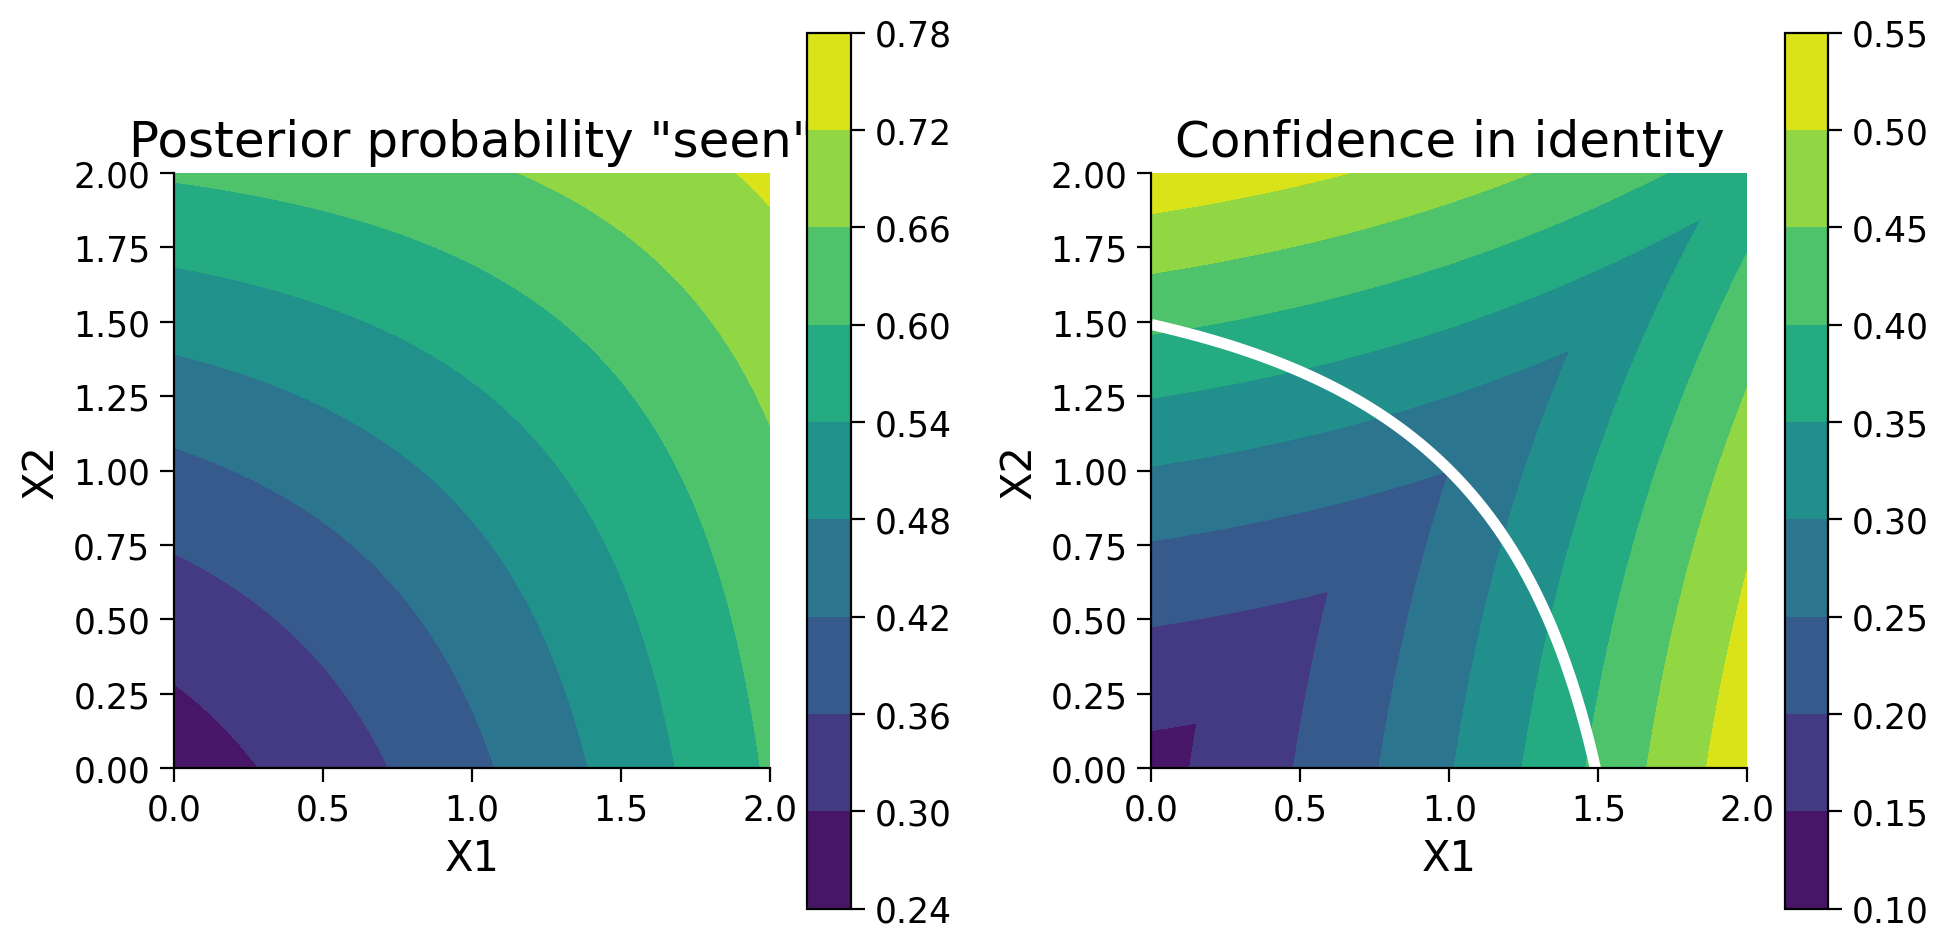

In [34]:
# Define the grid
xgrid = np.arange(0, 2.01, 0.01) 

# Define the means for the Gaussian distributions
mu = np.array([[0.5, 1.5], [1.5, 0.5], [0.5, 0.5]])

# Define the covariance matrix
Sigma = np.array([[1, 0], [0, 1]])

# Prior probabilities
Wprior = np.array([0.5, 0.5])
Aprior = 0.5

# Initialize arrays to hold confidence and posterior probability
confW = np.zeros((len(xgrid), len(xgrid)))
posteriorAware = np.zeros((len(xgrid), len(xgrid)))
KL_w = np.zeros((len(xgrid), len(xgrid)))
KL_A = np.zeros((len(xgrid), len(xgrid)))

# Compute confidence and posterior probability for each point in the grid
for i, xi in enumerate(xgrid):
    for j, xj in enumerate(xgrid):
        X = [xi, xj]
        post_w, post_A, KL_w[i, j], KL_A[i, j] = HOSS_evaluate(X, mu, Sigma, Aprior, Wprior)
        confW[i, j] = max(post_w[0], post_w[1]) 
        posteriorAware[i, j] = post_A[1]

# Plotting
plt.figure(figsize=(10, 5))

# Posterior probability "seen"
plt.subplot(1, 2, 1)
plt.contourf(xgrid, xgrid, posteriorAware.T)  
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Posterior probability "seen"')
plt.axis('square')

# Confidence in identity
plt.subplot(1, 2, 2)
contour_set = plt.contourf(xgrid, xgrid, confW.T)  
plt.colorbar()
plt.contour(xgrid, xgrid, posteriorAware.T, levels=[0.5], linewidths=4, colors=['white'])  # Line contour for threshold
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Confidence in identity')
plt.axis('square')

plt.show()

## Simulate KL divergence surfaces

We can also simulate K-L divergences (a measure of Bayesian surprise) at each layer in the network, which under predictive coding models of brain has been proposed to scale with neural activation (eg Friston, 2005; Summerfield & de Lange, 2014).

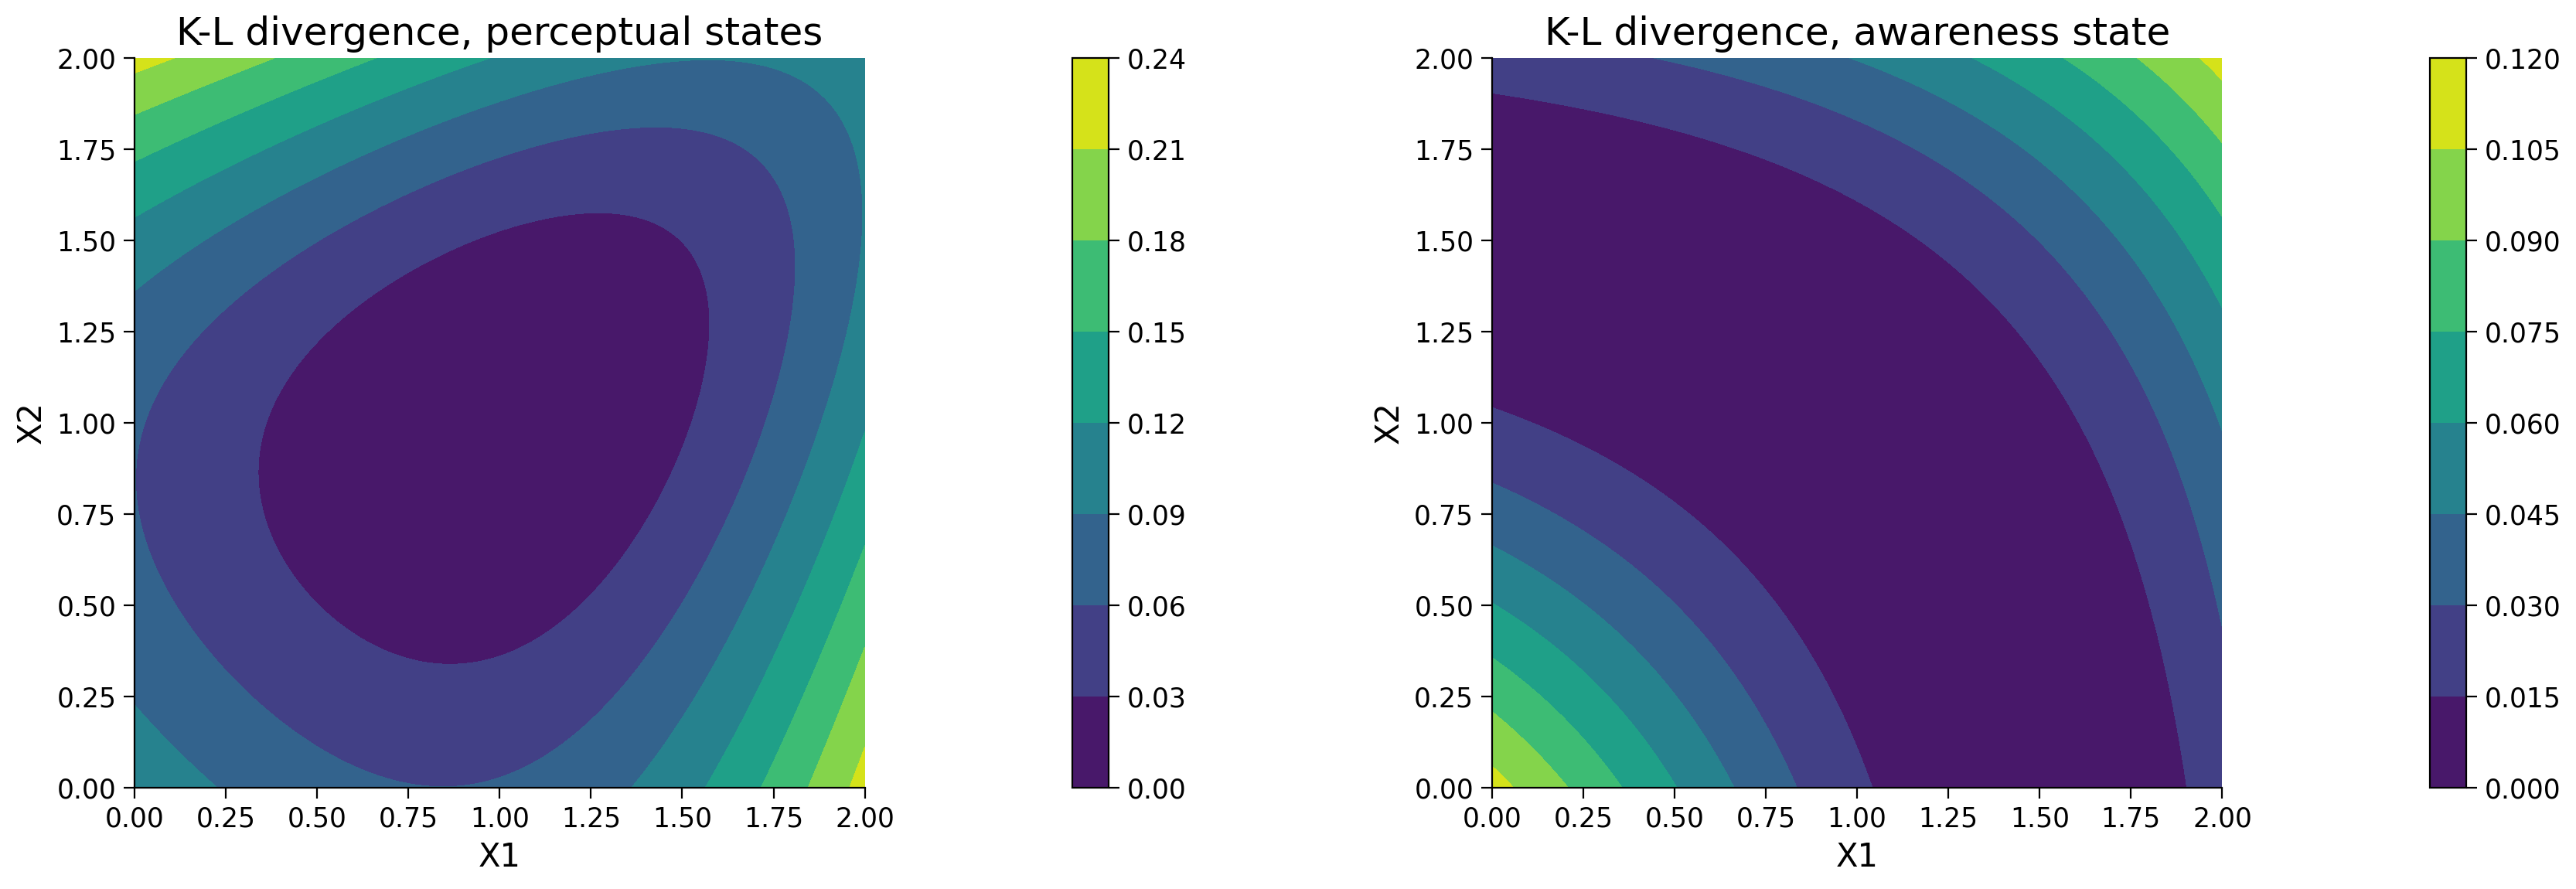

In [35]:
# Calculate the mean K-L divergence for absent and present awareness states
KL_A_absent = np.mean(KL_A[posteriorAware < 0.5])
KL_A_present = np.mean(KL_A[posteriorAware >= 0.5])
KL_w_absent = np.mean(KL_w[posteriorAware < 0.5])
KL_w_present = np.mean(KL_w[posteriorAware >= 0.5])

# Plotting
plt.figure(figsize=(18, 6))

# K-L divergence, perceptual states
plt.subplot(1, 2, 1)
plt.contourf(xgrid, xgrid, KL_w.T, cmap='viridis')  
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('K-L divergence, perceptual states')
plt.axis('square')

# K-L divergence, awareness state
plt.subplot(1, 2, 2)
plt.contourf(xgrid, xgrid, KL_A.T, cmap='viridis')  
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('K-L divergence, awareness state')
plt.axis('square')

plt.show()

## Discussion point

Can you recognise the difference between the K-L divergence for the W-level and the one for the A-level?

#### A hint

At the level of perceptual states W, there is substantial asymmetry in the K-L divergence expected when the model says ‘seen’ vs. ‘unseen’ (lefthand panel). This is due to the large belief updates invoked in the perceptual layer W by samples that deviate from the lower lefthand corner - from absence. In contrast, when we compute K-L divergence for the A-level (righthand panel), the level of prediction error is symmetric across seen and unseen decisions, leading to "hot" zones both at the upper righthand (present) and lower lefthand (absent) corners of the 2D space.

We can also sort the K-L divergences as a function of whether the model "reported" presence or absence. As can be seen in the bar plots below, there is more asymmetry in the prediction error at the W compared to the A levels.

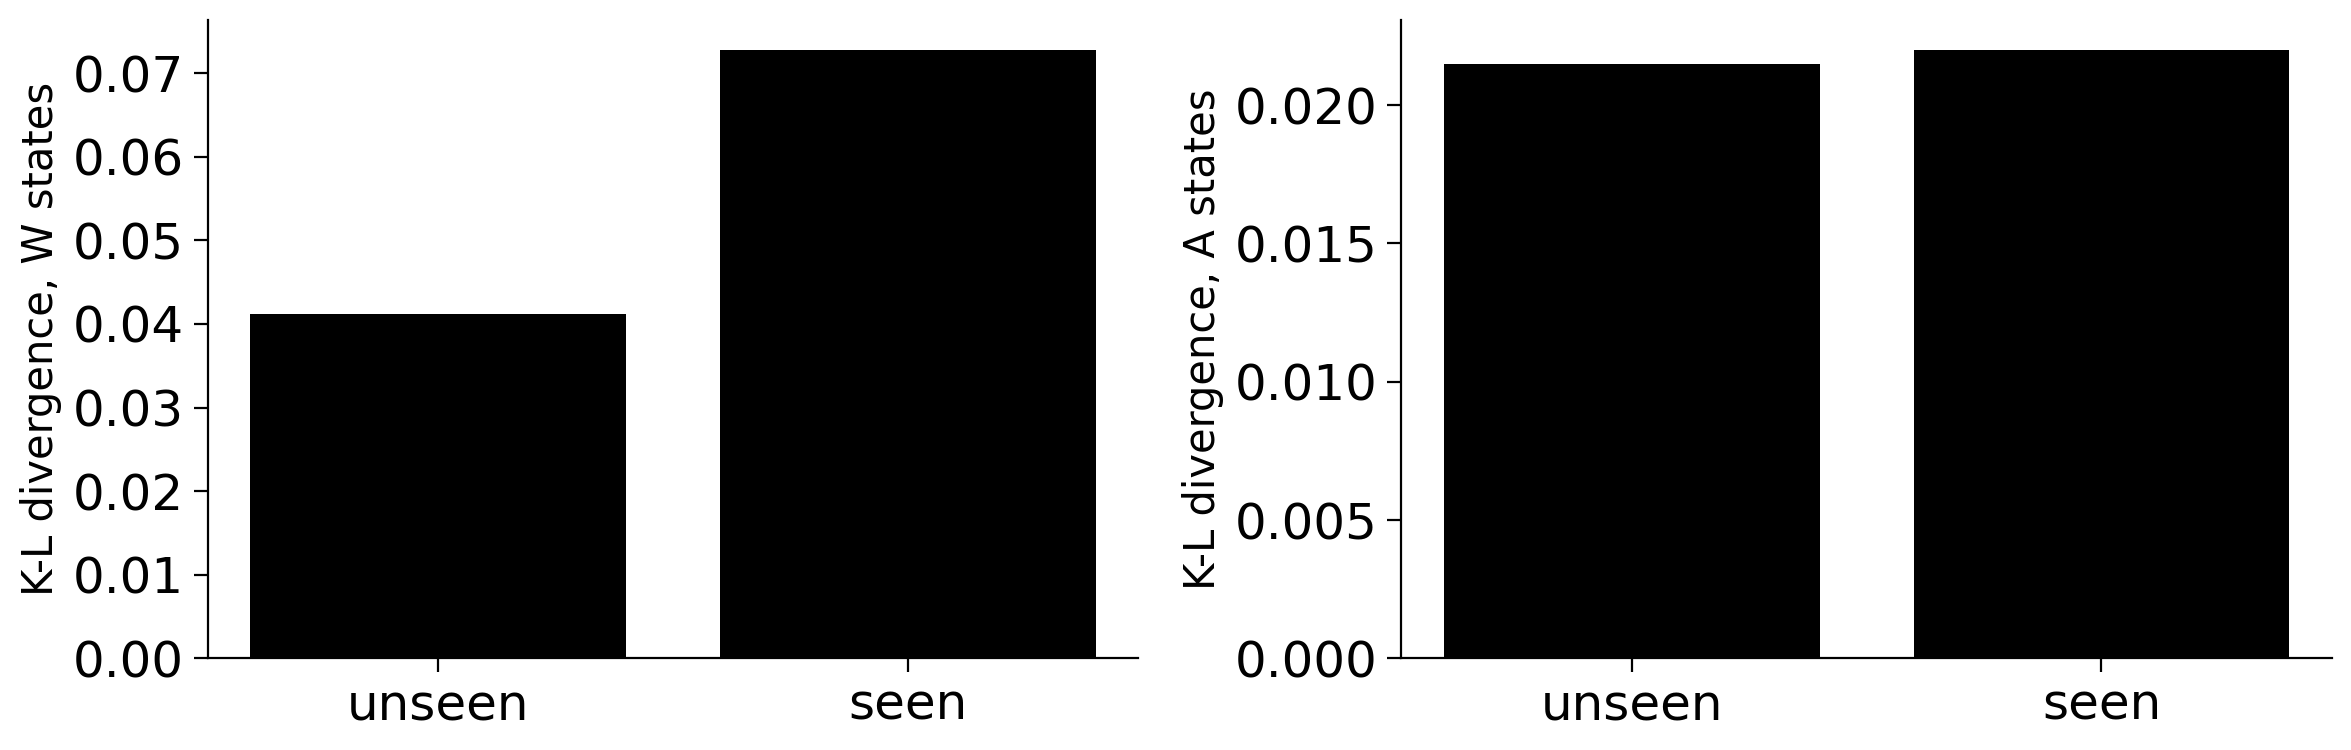

In [36]:
# Create figure with specified size
plt.figure(figsize=(12, 4))

# KL divergence for W states
plt.subplot(1, 2, 1)
plt.bar(['unseen', 'seen'], [KL_w_absent, KL_w_present], color='k')
plt.ylabel('K-L divergence, W states')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# KL divergence for A states
plt.subplot(1, 2, 2)
plt.bar(['unseen', 'seen'], [KL_A_absent, KL_A_present], color='k')
plt.ylabel('K-L divergence, A states')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

# Show plot
plt.show()

## Simulate ignition (asymmetry vs. symmetry)

A notable feature about the HOSS architecture is that it is asymmetric - there are naturally more possible (perceptual) states nested under "presence" than under "absence". As we saw in the previous section, this asymmetry in the state space suggests there will be greater summed prediction error in the entire network on presence decisions (as summarized by K-L divergence at each node of W). This may be a computational correlate of the global ignition responses often found to track awareness reports, and which is often interpreted as supporting global workspace models (e.g. Del Cul et al. 2007; Dehaene and Changeux 2011). We can simulate this by asking how the divergence in seen vs. unseen prediction error at the two levels seen in the previous plots changes as a function of stimulus strength - modeled here as sensory precision. Importantly, however, the explanation of ignition under HOSS is in terms of prediction error, rather than global broadcast. In other words, ignition is a epiphenomenal consequence of computations taking place elsewhere in the system, rather than constitutive of global information sharing.

In [37]:
# Experiment parameters
mu = np.array([[3.5, 0.5], [0.5, 3.5], [0.5, 0.5]])
Nsubjects = 30
Ntrials = 600
cond = np.concatenate((np.ones(Ntrials//3), np.ones(Ntrials//3)*2, np.ones(Ntrials//3)*3))
Wprior = [0.5, 0.5]
Aprior = 0.5

# Sensory precision values
gamma = np.linspace(0.1, 10, 6)

# Initialize lists for results
all_KL_w_yes = []
sem_KL_w_yes = []
all_KL_w_no = []
sem_KL_w_no = []
all_KL_A_yes = []
sem_KL_A_yes = []
all_KL_A_no = []
sem_KL_A_no = []
all_prob_y = []

#################################################
## TODO for students: fill in the missing variables ##
# Fill out function and remove
raise NotImplementedError("Student exercise: fill in the missing variables")
#################################################

for y in ...:
    Sigma = np.diag([1./np.sqrt(y)]*2)
    mean_KL_w = np.zeros((Nsubjects, 4))
    mean_KL_A = np.zeros((Nsubjects, 4))
    prob_y = np.zeros(Nsubjects)
    
    for s in range(Nsubjects):
        KL_w = np.zeros(len(cond))
        KL_A = np.zeros(len(cond))
        posteriorAware = np.zeros(len(cond))
        
        # Generate sensory samples
        X = np.array([multivariate_normal.rvs(mean=mu[int(c)-1, :], cov=Sigma) for c in cond])
        
        # Model inversion for each trial
        for i, x in enumerate(X):
            post_w, post_A, KL_w[i], KL_A[i] = HOSS_evaluate(x, mu, Sigma, Aprior, Wprior)
            posteriorAware[i] = post_A[1]  # Assuming post_A is a tuple with awareness probability at index 1
            
        binaryAware = posteriorAware > 0.5
        for i in range(4):
            conditions = [(cond == 3), (cond != 3), (cond != 3), (cond == 3)]
            aware_conditions = [(binaryAware == 0), (binaryAware == 0), (binaryAware == 1), (binaryAware == 1)]
            mean_KL_w[s, i] = np.mean(KL_w[np.logical_and(aware_conditions[i], conditions[i])])
            mean_KL_A[s, i] = np.mean(KL_A[np.logical_and(aware_conditions[i], conditions[i])])
        
        prob_y[s] = np.mean(binaryAware[cond != 3])
    
    # Aggregate results across subjects
    all_KL_w_yes.append(np.mean(mean_KL_w[:, 2:4].flatten()))
    sem_KL_w_yes.append(np.std(mean_KL_w[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_w_no.append(np.mean(mean_KL_w[:, :2].flatten()))
    sem_KL_w_no.append(np.std(mean_KL_w[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_yes.append(np.mean(mean_KL_A[:, 2:4].flatten()))
    sem_KL_A_yes.append(np.std(mean_KL_A[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_no.append(np.mean(mean_KL_A[:, :2].flatten()))
    sem_KL_A_no.append(np.std(mean_KL_A[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_prob_y.append(np.mean(prob_y))

# Create figure 
plt.figure(figsize=(16, 4.67))  

# First subplot: Probability of reporting "seen" for w_1 or w_2
plt.subplot(1, 3, 1)
plt.plot(gamma, all_prob_y, linewidth=2)
plt.xlabel('SOA (precision)')
plt.ylabel('Prob. report "seen" for w_1 or w_2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Second subplot: K-L divergence, perceptual states
plt.subplot(1, 3, 2)
plt.errorbar(gamma, all_KL_w_yes, yerr=sem_KL_w_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_w_no, yerr=sem_KL_w_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, perceptual states')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Third subplot: K-L divergence, awareness state
plt.subplot(1, 3, 3)
plt.errorbar(gamma, all_KL_A_yes, yerr=sem_KL_A_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_A_no, yerr=sem_KL_A_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, awareness state')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

NotImplementedError: Student exercise: fill in the missing variables

In [ ]:
# to remove solution

# Experiment parameters
mu = np.array([[3.5, 0.5], [0.5, 3.5], [0.5, 0.5]])
Nsubjects = 30
Ntrials = 600
cond = np.concatenate((np.ones(Ntrials//3), np.ones(Ntrials//3)*2, np.ones(Ntrials//3)*3))
Wprior = [0.5, 0.5]
Aprior = 0.5

# Sensory precision values
gamma = np.linspace(0.1, 10, 6)

# Initialize lists for results
all_KL_w_yes = []
sem_KL_w_yes = []
all_KL_w_no = []
sem_KL_w_no = []
all_KL_A_yes = []
sem_KL_A_yes = []
all_KL_A_no = []
sem_KL_A_no = []
all_prob_y = []

for y in gamma:
    Sigma = np.diag([1./np.sqrt(y)]*2)
    mean_KL_w = np.zeros((Nsubjects, 4))
    mean_KL_A = np.zeros((Nsubjects, 4))
    prob_y = np.zeros(Nsubjects)
    
    for s in range(Nsubjects):
        KL_w = np.zeros(len(cond))
        KL_A = np.zeros(len(cond))
        posteriorAware = np.zeros(len(cond))
        
        # Generate sensory samples
        X = np.array([multivariate_normal.rvs(mean=mu[int(c)-1, :], cov=Sigma) for c in cond])
        
        # Model inversion for each trial
        for i, x in enumerate(X):
            post_w, post_A, KL_w[i], KL_A[i] = HOSS_evaluate(x, mu, Sigma, Aprior, Wprior)
            posteriorAware[i] = post_A[1]  # Assuming post_A is a tuple with awareness probability at index 1
            
        binaryAware = posteriorAware > 0.5
        for i in range(4):
            conditions = [(cond == 3), (cond != 3), (cond != 3), (cond == 3)]
            aware_conditions = [(binaryAware == 0), (binaryAware == 0), (binaryAware == 1), (binaryAware == 1)]
            mean_KL_w[s, i] = np.mean(KL_w[np.logical_and(aware_conditions[i], conditions[i])])
            mean_KL_A[s, i] = np.mean(KL_A[np.logical_and(aware_conditions[i], conditions[i])])
        
        prob_y[s] = np.mean(binaryAware[cond != 3])
    
    # Aggregate results across subjects
    all_KL_w_yes.append(np.mean(mean_KL_w[:, 2:4].flatten()))
    sem_KL_w_yes.append(np.std(mean_KL_w[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_w_no.append(np.mean(mean_KL_w[:, :2].flatten()))
    sem_KL_w_no.append(np.std(mean_KL_w[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_yes.append(np.mean(mean_KL_A[:, 2:4].flatten()))
    sem_KL_A_yes.append(np.std(mean_KL_A[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_no.append(np.mean(mean_KL_A[:, :2].flatten()))
    sem_KL_A_no.append(np.std(mean_KL_A[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_prob_y.append(np.mean(prob_y))

# Create figure 
plt.figure(figsize=(16, 4.67))  

# First subplot: Probability of reporting "seen" for w_1 or w_2
plt.subplot(1, 3, 1)
plt.plot(gamma, all_prob_y, linewidth=2)
plt.xlabel('SOA (precision)')
plt.ylabel('Prob. report "seen" for w_1 or w_2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Second subplot: K-L divergence, perceptual states
plt.subplot(1, 3, 2)
plt.errorbar(gamma, all_KL_w_yes, yerr=sem_KL_w_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_w_no, yerr=sem_KL_w_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, perceptual states')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Third subplot: K-L divergence, awareness state
plt.subplot(1, 3, 3)
plt.errorbar(gamma, all_KL_A_yes, yerr=sem_KL_A_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_A_no, yerr=sem_KL_A_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, awareness state')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

## Discussion point

Can you think of experiments that could distinguish between the HOSS and GWS accounts of ignition?
